# Notebook 3: Model Setup and Evaluation

## Introduction

## Methodology

- Linear Regression
 - Count Vectorizer
     - Stemming
     - Lemmatization
- Ridge Regression




## Model Preprocessing

### Import Libraries
We begin by importing all the libraries required to run this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

from xgboost import XGBRegressor

import function_bank as fl

# the python string package has a helpful punctuation list
import string

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer



# Define some default visualizaiton display properties

# Ensure plots are always centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/allistaircota/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/allistaircota/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Read in Dataset

We now read in the review dataset that was cleaned in Notebook 2.

In [2]:
df = pd.read_csv('../data/review_data_cleaned.csv')
df.head()

,date,latitude,longitude,review_count,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsTakeOut,RestaurantsPriceRange2,...,Specialty Food,stars,useful,funny,cool,text,average_fans_per_user,reviews_per_week,repeat_customers,number_of_branches
0,2016-03-07 17:58:53,42.541155,-70.973438,39,1,1,1,1,1,2,...,0,4,0,0,0,Pizza here is delicious. I tried it once a few...,4.717949,0.057097,0,1
1,2014-05-10 11:35:46,42.475805,-70.926544,201,1,1,0,0,1,2,...,0,5,0,0,0,Delicious! My co-workers came back from lunch...,2.715596,0.353864,12,3
2,2014-07-18 14:36:15,42.520691,-70.894220,141,1,1,0,1,1,1,...,0,5,0,0,1,I really miss this place. I used to work in S...,8.937500,0.190339,2,1
3,2010-01-10 17:33:51,42.541155,-70.973438,39,1,1,1,1,1,2,...,0,4,1,0,0,love this place! really good pizza and probabl...,4.717949,0.057097,0,1
4,2012-02-13 05:53:37,42.540409,-71.153318,66,1,1,1,1,1,1,...,0,2,5,1,0,"Saw that they won a ""Sandie"" award from Phanto...",3.352941,0.109753,2,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 47 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   date                        1364840 non-null  object 
 1   latitude                    1364840 non-null  float64
 2   longitude                   1364840 non-null  float64
 3   review_count                1364840 non-null  int64  
 4   is_open                     1364840 non-null  int64  
 5   RestaurantsGoodForGroups    1364840 non-null  int64  
 6   HasTV                       1364840 non-null  int64  
 7   GoodForKids                 1364840 non-null  int64  
 8   RestaurantsTakeOut          1364840 non-null  int64  
 9   RestaurantsPriceRange2      1364840 non-null  int64  
 10  RestaurantsReservations     1364840 non-null  int64  
 11  RestaurantsAttire           1364840 non-null  object 
 12  RestaurantsDelivery         1364840 non-null  int64  
 1

### Converting Date Column

We can see that the `date` column is of an object data type. It would be more convenient, if we could extract the individual components of the date as separate numeric columns (e.g. year, month, etc., of the review). To do this, we first convert the `date` column to a `datetime` format and then extract the components of interest. 

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.insert(loc=0, column='Year', value=df['date'].dt.year)
df.insert(loc=1, column='Month', value=df['date'].dt.month)
df.insert(loc=2, column='Day', value=df['date'].dt.day)
df.insert(loc=3, column='Day of Week', value=df['date'].dt.weekday)
df.insert(loc=4, column='Hour', value=df['date'].dt.hour)
df.insert(loc=5, column='Minute', value=df['date'].dt.minute)
df.drop('date', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 52 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Year                        1364840 non-null  int64  
 1   Month                       1364840 non-null  int64  
 2   Day                         1364840 non-null  int64  
 3   Day of Week                 1364840 non-null  int64  
 4   Hour                        1364840 non-null  int64  
 5   Minute                      1364840 non-null  int64  
 6   latitude                    1364840 non-null  float64
 7   longitude                   1364840 non-null  float64
 8   review_count                1364840 non-null  int64  
 9   is_open                     1364840 non-null  int64  
 10  RestaurantsGoodForGroups    1364840 non-null  int64  
 11  HasTV                       1364840 non-null  int64  
 12  GoodForKids                 1364840 non-null  int64  
 1

We have successfully converted the date components to separate integer columns.

### Ordering the columns

We will be using a column transformer later in this notebook to apply specific transformations to certain columns based on their data type and the information that each contains. Hence, it will be convenient to reorder the columns in a convenient order, based on the order the column transformations will be applied. For now, we will move all columns of the `object` data type to the end of the data frame. 

In [5]:
# Get  columns whose data type is object
object_columns = df.dtypes[df.dtypes == 'object']

# Put the object column names into a list
object_columns = object_columns.index.tolist()
object_columns

['RestaurantsAttire', 'NoiseLevel', 'Alcohol', 'WiFi', 'text']

In [6]:
# Keep the object type columns in a temporary data frame
temp_df = df[object_columns]
temp_df

,RestaurantsAttire,NoiseLevel,Alcohol,WiFi,text
0,casual,average,none,free,Pizza here is delicious. I tried it once a few...
1,casual,average,full_bar,free,Delicious! My co-workers came back from lunch...
2,casual,average,none,no,I really miss this place. I used to work in S...
3,casual,average,none,free,love this place! really good pizza and probabl...
4,casual,average,none,no,"Saw that they won a ""Sandie"" award from Phanto..."
...,...,...,...,...,...
1364835,casual,average,beer_and_wine,no,We need restaurants like this to remind us whe...
1364836,casual,average,beer_and_wine,no,Food is good but small portions ! A bit overly...
1364837,casual,average,beer_and_wine,no,I had orders the pasta carbonara for a pick up...
1364838,casual,average,full_bar,no,"As I said, my family and I gave the Jury Room ..."


In [7]:
# Merge the data frame without object columns with the temporary data frame

df = pd.concat([df.drop(columns = object_columns), temp_df], axis=1)
df.head()


,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,cool,average_fans_per_user,reviews_per_week,repeat_customers,number_of_branches,RestaurantsAttire,NoiseLevel,Alcohol,WiFi,text
0,2016,3,7,0,17,58,42.541155,-70.973438,39,1,...,0,4.717949,0.057097,0,1,casual,average,none,free,Pizza here is delicious. I tried it once a few...
1,2014,5,10,5,11,35,42.475805,-70.926544,201,1,...,0,2.715596,0.353864,12,3,casual,average,full_bar,free,Delicious! My co-workers came back from lunch...
2,2014,7,18,4,14,36,42.520691,-70.894220,141,1,...,1,8.937500,0.190339,2,1,casual,average,none,no,I really miss this place. I used to work in S...
3,2010,1,10,6,17,33,42.541155,-70.973438,39,1,...,0,4.717949,0.057097,0,1,casual,average,none,free,love this place! really good pizza and probabl...
4,2012,2,13,0,5,53,42.540409,-71.153318,66,1,...,0,3.352941,0.109753,2,1,casual,average,none,no,"Saw that they won a ""Sandie"" award from Phanto..."


### Define X and y

We are now ready to define our independent variable array `X` and our dependent variable `y`. Our dependent variable is the number of stars (i.e. the `stars` column).

In [8]:
X = df.drop(['stars'], axis=1)
X.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,cool,average_fans_per_user,reviews_per_week,repeat_customers,number_of_branches,RestaurantsAttire,NoiseLevel,Alcohol,WiFi,text
0,2016,3,7,0,17,58,42.541155,-70.973438,39,1,...,0,4.717949,0.057097,0,1,casual,average,none,free,Pizza here is delicious. I tried it once a few...
1,2014,5,10,5,11,35,42.475805,-70.926544,201,1,...,0,2.715596,0.353864,12,3,casual,average,full_bar,free,Delicious! My co-workers came back from lunch...
2,2014,7,18,4,14,36,42.520691,-70.894220,141,1,...,1,8.937500,0.190339,2,1,casual,average,none,no,I really miss this place. I used to work in S...
3,2010,1,10,6,17,33,42.541155,-70.973438,39,1,...,0,4.717949,0.057097,0,1,casual,average,none,free,love this place! really good pizza and probabl...
4,2012,2,13,0,5,53,42.540409,-71.153318,66,1,...,0,3.352941,0.109753,2,1,casual,average,none,no,"Saw that they won a ""Sandie"" award from Phanto..."


In [9]:
y = df['stars']
y.head()

0    4
1    5
2    5
3    4
4    2
Name: stars, dtype: int64

It would be good to view the distribution of our dependent variable.

In [10]:
list(enumerate(y.value_counts().sort_index()))

[(0, 161360), (1, 139469), (2, 192475), (3, 378060), (4, 493476)]

/var/folders/mj/wygw49hn45s4xjsgwgykrkc40000gn/T/ipykernel_2723/65967193.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


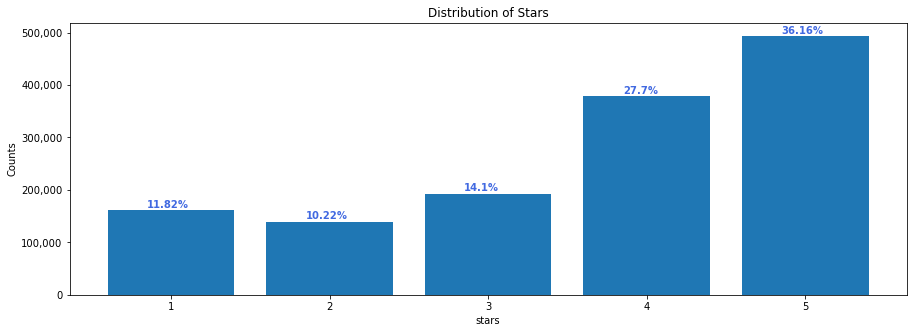

In [11]:
plt.figure(figsize=(15,5))
plt.bar(y.value_counts().sort_index().index.astype('str'),
        y.value_counts().sort_index())
plt.title('Distribution of Stars')
plt.xlabel('stars')
plt.ylabel('Counts')

axes = plt.gca()
axes.set_axisbelow(True)

for i, j in enumerate(y.value_counts().sort_index()):
    axes.text(i-0.15, j + 5000, str(round(j/X.shape[0]*100,2))+'%', color='royalblue', fontweight='bold')

current_values = axes.get_yticks()
axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

Our distribution is left skewed. However, we do have a reasonable distribution across all the possible number of ratings.

### Checking Correlation of Numeric Columns with Rating

In [12]:
fl.correlation_coeff(X.drop(columns=object_columns), y)

,Variable,Correlation Coefficient,p-value
0,Day,0.000464,5.878830e-01
1,Minute,-0.000980,2.524647e-01
2,longitude,0.001961,2.198227e-02
3,average_fans_per_user,0.002826,9.624271e-04
4,GoodForKids,0.002975,5.091648e-04
5,OutdoorSeating,-0.004986,5.697669e-09
6,Salad,0.005149,1.792507e-09
7,Month,-0.005621,5.155104e-11
8,latitude,0.006700,4.961500e-15
9,American (New),-0.009541,7.422744e-29


In [13]:
#X.drop(['Day', 'Minute'], axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 51 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Year                        1364840 non-null  int64  
 1   Month                       1364840 non-null  int64  
 2   Day                         1364840 non-null  int64  
 3   Day of Week                 1364840 non-null  int64  
 4   Hour                        1364840 non-null  int64  
 5   Minute                      1364840 non-null  int64  
 6   latitude                    1364840 non-null  float64
 7   longitude                   1364840 non-null  float64
 8   review_count                1364840 non-null  int64  
 9   is_open                     1364840 non-null  int64  
 10  RestaurantsGoodForGroups    1364840 non-null  int64  
 11  HasTV                       1364840 non-null  int64  
 12  GoodForKids                 1364840 non-null  int64  
 1

### Checking for Multicollinearity

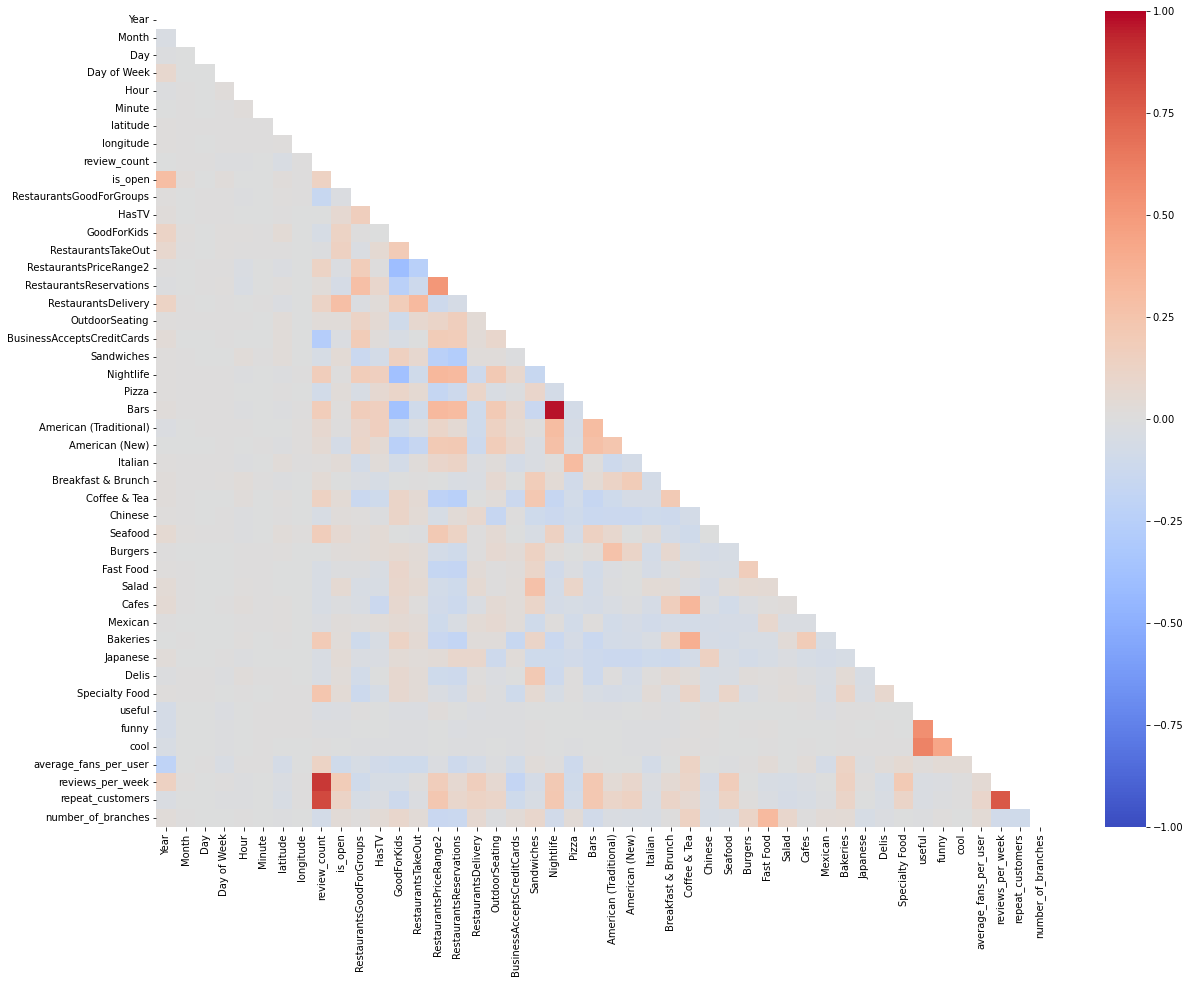

In [14]:
fl.corr_matrix_heatmap(X)

In [15]:
print(f"{stats.pearsonr(X['Bars'], X['Nightlife'])}")
print(f" Correlation of Bars with Stars {stats.pearsonr(X['Bars'], y)}")
print(f" Correlation of Nightlife with Stars {stats.pearsonr(X['Nightlife'], y)}")


(0.9756265437729745, 0.0)
 Correlation of Bars with Stars (-0.01024077266579386, 5.4705721859526906e-33)
 Correlation of Nightlife with Stars (-0.01522788913121939, 8.268286162245917e-71)


In [16]:
X.drop(['Nightlife', 'review_count'], axis=1, inplace=True)

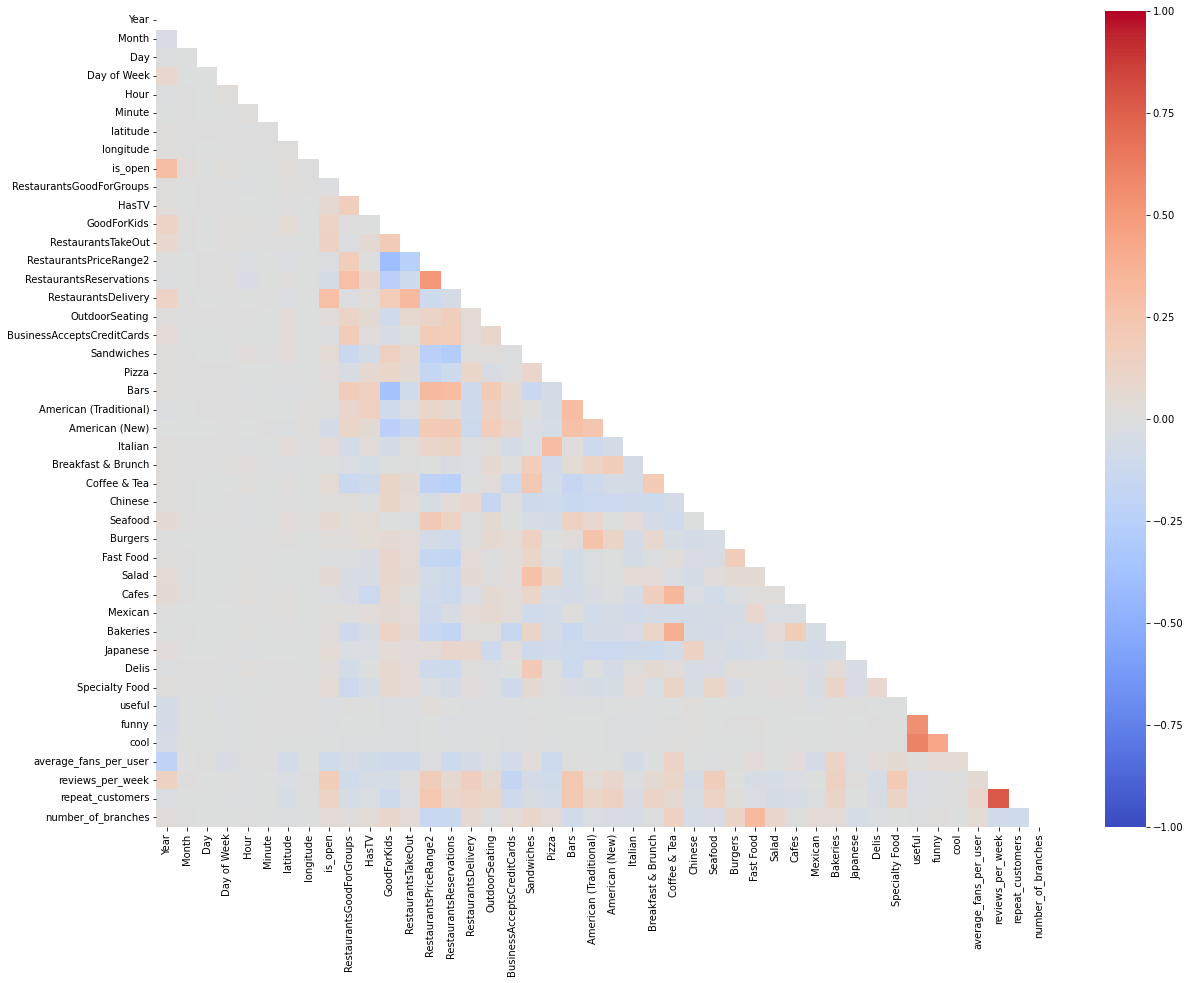

In [17]:
fl.corr_matrix_heatmap(X)

In [18]:
stats.pearsonr(X['reviews_per_week'], X['repeat_customers'])

(0.7803776845662647, 0.0)

### Sampling the Data

Due to the large dataset (1.3 million reviews) which includes text data, and computing hardware limitations, we will subsample our dataset so that the dataset is more manageable more model training and evaluation. We will use the `resample` method from Scikit-Learn, sampling without replacement, and stratifying based on y. For this project, we will utilize around 13,000 reviews (~1% of the original dataset).

In [19]:
X_sampled, y_sampled = resample(X, y, random_state=0, 
                                    n_samples = 0.01*X.shape[0],
                                    replace=False, stratify=y)

In [20]:
print(f'X_sampled shape: {X_sampled.shape}')
print(f'y_sampled shape: {y_sampled.shape}')

X_sampled shape: (13648, 49)
y_sampled shape: (13648,)


Our sampled dataset has 13,648 rows and 50 columns. Let's take a look at the distribution of our dependent variable in this sample.

/var/folders/mj/wygw49hn45s4xjsgwgykrkc40000gn/T/ipykernel_2723/1967618503.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


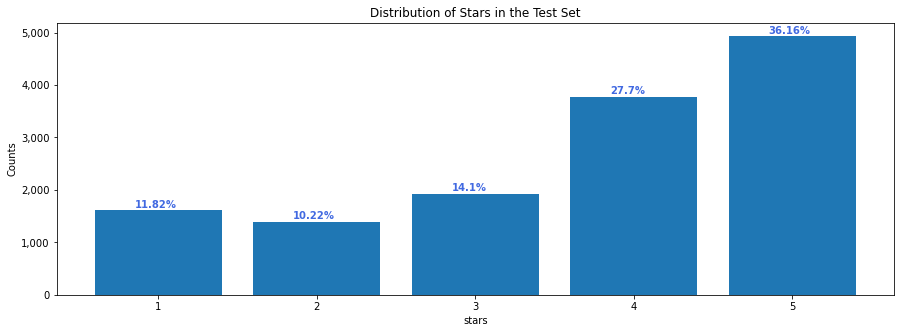

In [21]:
plt.figure(figsize=(15,5))
plt.bar(y_sampled.value_counts().sort_index().index.astype('str'),
        y_sampled.value_counts().sort_index())
plt.title('Distribution of Stars in the Test Set')
plt.xlabel('stars')
plt.ylabel('Counts')

axes = plt.gca()
axes.set_axisbelow(True)

for i, j in enumerate(y_sampled.value_counts().sort_index()):
    axes.text(i-0.15, j + 50, str(round(j/X_sampled.shape[0]*100,2))+'%', color='royalblue', fontweight='bold')

current_values = axes.get_yticks()
axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

The stratification worked as intended, since our dependent variable distribution in this sample is very similar to its distribution in the overall dataset.

In [22]:
X_sampled.columns

Index(['Year', 'Month', 'Day', 'Day of Week', 'Hour', 'Minute', 'latitude',
       'longitude', 'is_open', 'RestaurantsGoodForGroups', 'HasTV',
       'GoodForKids', 'RestaurantsTakeOut', 'RestaurantsPriceRange2',
       'RestaurantsReservations', 'RestaurantsDelivery', 'OutdoorSeating',
       'BusinessAcceptsCreditCards', 'Sandwiches', 'Pizza', 'Bars',
       'American (Traditional)', 'American (New)', 'Italian',
       'Breakfast & Brunch', 'Coffee & Tea', 'Chinese', 'Seafood', 'Burgers',
       'Fast Food', 'Salad', 'Cafes', 'Mexican', 'Bakeries', 'Japanese',
       'Delis', 'Specialty Food', 'useful', 'funny', 'cool',
       'average_fans_per_user', 'reviews_per_week', 'repeat_customers',
       'number_of_branches', 'RestaurantsAttire', 'NoiseLevel', 'Alcohol',
       'WiFi', 'text'],
      dtype='object')

## Modelling

### Defining Train and Test Sets

In [23]:
# Splitting out 20% for test set
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size = 0.2, stratify=y_sampled, random_state=0)

print(f'Shape of X_train: {X_train.shape}. Shaper of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}. Shaper of y_test: {y_test.shape}')

Shape of X_train: (10918, 49). Shaper of y_train: (10918,)
Shape of X_test: (2730, 49). Shaper of y_test: (2730,)


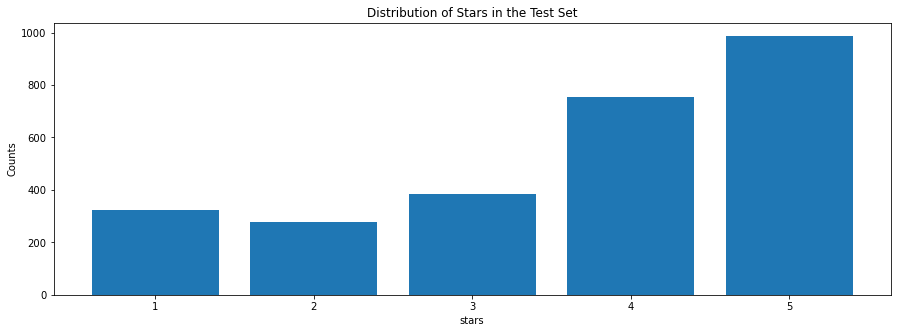

In [24]:
plt.figure(figsize=(15,5))
plt.bar(y_test.value_counts().sort_index().index.astype('str'),
        y_test.value_counts().sort_index())
plt.title('Distribution of Stars in the Test Set')
plt.xlabel('stars')
plt.ylabel('Counts')
plt.show()

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10918 entries, 118838 to 910818
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        10918 non-null  int64  
 1   Month                       10918 non-null  int64  
 2   Day                         10918 non-null  int64  
 3   Day of Week                 10918 non-null  int64  
 4   Hour                        10918 non-null  int64  
 5   Minute                      10918 non-null  int64  
 6   latitude                    10918 non-null  float64
 7   longitude                   10918 non-null  float64
 8   is_open                     10918 non-null  int64  
 9   RestaurantsGoodForGroups    10918 non-null  int64  
 10  HasTV                       10918 non-null  int64  
 11  GoodForKids                 10918 non-null  int64  
 12  RestaurantsTakeOut          10918 non-null  int64  
 13  RestaurantsPriceRange2   

### Bag of Words with Stemming

In [26]:
# numeric_columns = X_train.dtypes[df.dtypes != 'object'].index.to_list()
# numeric_columns

In [27]:
categorical_columns = X_train.drop('text', axis=1).dtypes[df.dtypes == 'object'].index.to_list()
categorical_columns

['RestaurantsAttire', 'NoiseLevel', 'Alcohol', 'WiFi']

In [28]:
def tokenizer_prep(sentence):
    # remove punctuation and set to lower case
    english_stop_words = stopwords.words('english')
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    return english_stop_words, listofwords


def tokenizer_stemming(sentence):
    stemmer = PorterStemmer()
    english_stop_words, listofwords = tokenizer_prep(sentence) 
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in english_stop_words) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

def tokenizer_lemmatizer(sentence):
    lemmatizer = WordNetLemmatizer()
    english_stop_words, listofwords = tokenizer_prep(sentence) 
    listoflemmatized_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in english_stop_words) and (word!=''):
            # Lematized words
            lemmatized_word = lemmatizer.lemmatize(word)
            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words


In [29]:
trans_dict = {'1a': 'Bag of Words with Stemming',
              '1b': 'Bag of Words with Lemmatization',
              '2a': 'TF-IDF with Stemming',
              '2b': 'TF-IDF with Lemmatization'}

In [30]:
trans_1a = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_columns),
    ('review', CountVectorizer(tokenizer=tokenizer_stemming, min_df=25), 'text')
])

trans_1b = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_columns),
    ('review', CountVectorizer(tokenizer=tokenizer_lemmatizer, min_df=25), 'text')
])

trans_2a = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_columns),
    ('review', TfidfVectorizer(min_df=25, tokenizer=tokenizer_stemming), 'text')
])

trans_2b = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_columns),
    ('review', TfidfVectorizer(min_df=25, tokenizer=tokenizer_lemmatizer), 'text')
])

scaler = MinMaxScaler()

In [31]:
%%time
######## Transformation 1a: Bag of Words with Stemming #######

## Train Set

# Fit & transform training set
temp_df = trans_1a.fit_transform(X_train).todense()

# Make column trasnformer output a data frame
temp_df = pd.DataFrame(columns=trans_1a.get_feature_names_out(), data=temp_df, index=X_train.index)

# Concatentate column transformed columns with rest of data frame
X_train_unscaled_1a = pd.concat([X_train.drop(categorical_columns+['text'], axis=1), temp_df], axis=1)

# Create scaled data frame
X_train_scaled_1a = scaler.fit_transform(X_train_unscaled_1a)
X_train_scaled_1a = pd.DataFrame(X_train_scaled_1a, columns=X_train_unscaled_1a.columns)


## Test Set

# Transform training set
temp_df = trans_1a.transform(X_test).todense()
# Make column trasnformer output a data frame
temp_df = pd.DataFrame(columns=trans_1a.get_feature_names_out(), data=temp_df, index=X_test.index)
# Concatentate column transformed columns with rest of data frame
X_test_unscaled_1a = pd.concat([X_test.drop(categorical_columns+['text'], axis=1), temp_df], axis=1)

# Create scaled data frame
X_test_scaled_1a = scaler.fit_transform(X_test_unscaled_1a)
X_test_scaled_1a = pd.DataFrame(X_test_scaled_1a, columns=X_test_unscaled_1a.columns)

# Print shapes
print(f'Shape of unscaled train set for : {X_train_unscaled_1a.shape}')
print(f'Shape of scaled train set for : {X_train_scaled_1a.shape}')
print(f'Shape of unscaled test set for : {X_test_unscaled_1a.shape}')
print(f'Shape of scaled test set: {X_test_scaled_1a.shape}')

Shape of unscaled train set for : (10918, 2298)
Shape of scaled train set for : (10918, 2298)
Shape of unscaled test set for : (2730, 2298)
Shape of scaled test set: (2730, 2298)
CPU times: user 19.5 s, sys: 1.12 s, total: 20.6 s
Wall time: 20.6 s


In [32]:
%%time
######## Transformation 1b: Bag of Words with Lemmatization #######

## Train Set

# Fit & transform training set
temp_df = trans_1b.fit_transform(X_train).todense()

# Make column trasnformer output a data frame
temp_df = pd.DataFrame(columns=trans_1b.get_feature_names_out(), data=temp_df, index=X_train.index)

# Concatentate column transformed columns with rest of data frame
X_train_unscaled_1b = pd.concat([X_train.drop(categorical_columns+['text'], axis=1), temp_df], axis=1)

# Create scaled data frame
X_train_scaled_1b = scaler.fit_transform(X_train_unscaled_1b)
X_train_scaled_1b = pd.DataFrame(X_train_scaled_1b, columns=X_train_unscaled_1b.columns)


## Test Set

# Transform training set
temp_df = trans_1b.transform(X_test).todense()
# Make column trasnformer output a data frame
temp_df = pd.DataFrame(columns=trans_1b.get_feature_names_out(), data=temp_df, index=X_test.index)
# Concatentate column transformed columns with rest of data frame
X_test_unscaled_1b = pd.concat([X_test.drop(categorical_columns+['text'], axis=1), temp_df], axis=1)

# Create scaled data frame
X_test_scaled_1b = scaler.fit_transform(X_test_unscaled_1b)
X_test_scaled_1b = pd.DataFrame(X_test_scaled_1b, columns=X_test_unscaled_1b.columns)

# Print shapes
print(f'Shape of unscaled train set for : {X_train_unscaled_1b.shape}')
print(f'Shape of scaled train set for : {X_train_scaled_1b.shape}')
print(f'Shape of unscaled test set for : {X_test_unscaled_1b.shape}')
print(f'Shape of scaled test set: {X_test_scaled_1b.shape}')

Shape of unscaled train set for : (10918, 2505)
Shape of scaled train set for : (10918, 2505)
Shape of unscaled test set for : (2730, 2505)
Shape of scaled test set: (2730, 2505)
CPU times: user 10.3 s, sys: 1.19 s, total: 11.5 s
Wall time: 11.5 s


In [33]:
%%time
######## Transformation 2a: TF-IDF with Stemming #######

## Train Set

# Fit & transform training set
temp_df = trans_2a.fit_transform(X_train).todense()

# Make column trasnformer output a data frame
temp_df = pd.DataFrame(columns=trans_2a.get_feature_names_out(), data=temp_df, index=X_train.index)

# Concatentate column transformed columns with rest of data frame
X_train_unscaled_2a = pd.concat([X_train.drop(categorical_columns+['text'], axis=1), temp_df], axis=1)

# Create scaled data frame
X_train_scaled_2a = scaler.fit_transform(X_train_unscaled_2a)
X_train_scaled_2a = pd.DataFrame(X_train_scaled_2a, columns=X_train_unscaled_2a.columns)


## Test Set

# Transform training set
temp_df = trans_2a.transform(X_test).todense()
# Make column trasnformer output a data frame
temp_df = pd.DataFrame(columns=trans_2a.get_feature_names_out(), data=temp_df, index=X_test.index)
# Concatentate column transformed columns with rest of data frame
X_test_unscaled_2a = pd.concat([X_test.drop(categorical_columns+['text'], axis=1), temp_df], axis=1)

# Create scaled data frame
X_test_scaled_2a = scaler.fit_transform(X_test_unscaled_2a)
X_test_scaled_2a = pd.DataFrame(X_test_scaled_2a, columns=X_test_unscaled_2a.columns)

# Print shapes
print(f'Shape of unscaled train set for : {X_train_unscaled_2a.shape}')
print(f'Shape of scaled train set for : {X_train_scaled_2a.shape}')
print(f'Shape of unscaled test set for : {X_test_unscaled_2a.shape}')
print(f'Shape of scaled test set: {X_test_scaled_2a.shape}')

Shape of unscaled train set for : (10918, 2298)
Shape of scaled train set for : (10918, 2298)
Shape of unscaled test set for : (2730, 2298)
Shape of scaled test set: (2730, 2298)
CPU times: user 18.1 s, sys: 905 ms, total: 19 s
Wall time: 19.1 s


In [34]:
%%time
######## Transformation 2b: TF-IDF with Lemmatization #######

## Train Set

# Fit & transform training set
temp_df = trans_2b.fit_transform(X_train).todense()

# Make column trasnformer output a data frame
temp_df = pd.DataFrame(columns=trans_2b.get_feature_names_out(), data=temp_df, index=X_train.index)

# Concatentate column transformed columns with rest of data frame
X_train_unscaled_2b = pd.concat([X_train.drop(categorical_columns+['text'], axis=1), temp_df], axis=1)

# Create scaled data frame
X_train_scaled_2b = scaler.fit_transform(X_train_unscaled_2b)
X_train_scaled_2b = pd.DataFrame(X_train_scaled_2b, columns=X_train_unscaled_2b.columns)


## Test Set

# Transform training set
temp_df = trans_2b.transform(X_test).todense()
# Make column trasnformer output a data frame
temp_df = pd.DataFrame(columns=trans_2b.get_feature_names_out(), data=temp_df, index=X_test.index)
# Concatentate column transformed columns with rest of data frame
X_test_unscaled_2b = pd.concat([X_test.drop(categorical_columns+['text'], axis=1), temp_df], axis=1)

# Create scaled data frame
X_test_scaled_2b = scaler.fit_transform(X_test_unscaled_2b)
X_test_scaled_2b = pd.DataFrame(X_test_scaled_2b, columns=X_test_unscaled_2b.columns)

# Print shapes
print(f'Shape of unscaled train set for : {X_train_unscaled_2b.shape}')
print(f'Shape of scaled train set for : {X_train_scaled_2b.shape}')
print(f'Shape of unscaled test set for : {X_test_unscaled_2b.shape}')
print(f'Shape of scaled test set: {X_test_scaled_2b.shape}')

Shape of unscaled train set for : (10918, 2505)
Shape of scaled train set for : (10918, 2505)
Shape of unscaled test set for : (2730, 2505)
Shape of scaled test set: (2730, 2505)
CPU times: user 7.9 s, sys: 888 ms, total: 8.79 s
Wall time: 8.86 s


In [35]:
X_train_unscaled_1a.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__your,review__youv,review__yum,review__yummi,review__zero,review__zucchini
118838,2010,11,7,6,12,43,42.395293,-71.121620,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
984277,2018,10,4,3,14,8,42.353567,-71.058031,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778602,2020,8,9,6,1,19,42.340918,-71.081615,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
483464,2008,7,17,3,0,17,42.363968,-71.101869,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496132,2019,1,31,3,20,50,42.321512,-71.175672,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X_train_scaled_1a.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__your,review__youv,review__yum,review__yummi,review__zero,review__zucchini
0,0.3125,0.909091,0.200000,1.0,0.521739,0.728814,0.586507,0.001951,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.8125,0.818182,0.100000,0.5,0.608696,0.135593,0.503246,0.002397,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.9375,0.636364,0.266667,1.0,0.043478,0.322034,0.478006,0.002232,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.1875,0.545455,0.533333,0.5,0.000000,0.288136,0.524001,0.002089,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.8750,0.000000,1.000000,0.5,0.869565,0.847458,0.439284,0.001572,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X_test_unscaled_1a.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__your,review__youv,review__yum,review__yummi,review__zero,review__zucchini
719576,2019,4,21,6,22,35,42.339823,-71.091285,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1033835,2020,1,12,6,2,31,42.448745,-71.228743,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37835,2012,7,8,6,2,56,42.387212,-71.118532,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256789,2015,12,15,1,1,28,42.359075,-71.059176,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
688708,2011,8,26,4,19,4,42.379939,-71.094383,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
X_test_scaled_1a.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__your,review__youv,review__yum,review__yummi,review__zero,review__zucchini
0,0.882353,0.272727,0.666667,1.000000,0.956522,0.593220,0.483160,0.516670,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.941176,0.000000,0.366667,1.000000,0.086957,0.525424,0.703154,0.286439,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.470588,0.545455,0.233333,1.000000,0.086957,0.949153,0.578875,0.471033,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.647059,1.000000,0.466667,0.166667,0.043478,0.474576,0.522044,0.570450,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.411765,0.636364,0.833333,0.666667,0.826087,0.067797,0.564184,0.511481,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
X_train_unscaled_1b.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__youre,review__youve,review__yum,review__yummy,review__zero,review__zucchini
118838,2010,11,7,6,12,43,42.395293,-71.121620,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
984277,2018,10,4,3,14,8,42.353567,-71.058031,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778602,2020,8,9,6,1,19,42.340918,-71.081615,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
483464,2008,7,17,3,0,17,42.363968,-71.101869,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496132,2019,1,31,3,20,50,42.321512,-71.175672,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
X_train_scaled_1b.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__youre,review__youve,review__yum,review__yummy,review__zero,review__zucchini
0,0.3125,0.909091,0.200000,1.0,0.521739,0.728814,0.586507,0.001951,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.8125,0.818182,0.100000,0.5,0.608696,0.135593,0.503246,0.002397,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.9375,0.636364,0.266667,1.0,0.043478,0.322034,0.478006,0.002232,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.1875,0.545455,0.533333,0.5,0.000000,0.288136,0.524001,0.002089,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.8750,0.000000,1.000000,0.5,0.869565,0.847458,0.439284,0.001572,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
X_test_unscaled_1b.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__youre,review__youve,review__yum,review__yummy,review__zero,review__zucchini
719576,2019,4,21,6,22,35,42.339823,-71.091285,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1033835,2020,1,12,6,2,31,42.448745,-71.228743,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37835,2012,7,8,6,2,56,42.387212,-71.118532,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256789,2015,12,15,1,1,28,42.359075,-71.059176,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
688708,2011,8,26,4,19,4,42.379939,-71.094383,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
X_test_scaled_1b.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__youre,review__youve,review__yum,review__yummy,review__zero,review__zucchini
0,0.882353,0.272727,0.666667,1.000000,0.956522,0.593220,0.483160,0.516670,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.941176,0.000000,0.366667,1.000000,0.086957,0.525424,0.703154,0.286439,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.470588,0.545455,0.233333,1.000000,0.086957,0.949153,0.578875,0.471033,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.647059,1.000000,0.466667,0.166667,0.043478,0.474576,0.522044,0.570450,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.411765,0.636364,0.833333,0.666667,0.826087,0.067797,0.564184,0.511481,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
X_train_unscaled_2a.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__your,review__youv,review__yum,review__yummi,review__zero,review__zucchini
118838,2010,11,7,6,12,43,42.395293,-71.121620,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
984277,2018,10,4,3,14,8,42.353567,-71.058031,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778602,2020,8,9,6,1,19,42.340918,-71.081615,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
483464,2008,7,17,3,0,17,42.363968,-71.101869,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496132,2019,1,31,3,20,50,42.321512,-71.175672,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
X_train_scaled_2a.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__your,review__youv,review__yum,review__yummi,review__zero,review__zucchini
0,0.3125,0.909091,0.200000,1.0,0.521739,0.728814,0.586507,0.001951,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.8125,0.818182,0.100000,0.5,0.608696,0.135593,0.503246,0.002397,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.9375,0.636364,0.266667,1.0,0.043478,0.322034,0.478006,0.002232,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.1875,0.545455,0.533333,0.5,0.000000,0.288136,0.524001,0.002089,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.8750,0.000000,1.000000,0.5,0.869565,0.847458,0.439284,0.001572,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
X_test_unscaled_2a.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__your,review__youv,review__yum,review__yummi,review__zero,review__zucchini
719576,2019,4,21,6,22,35,42.339823,-71.091285,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1033835,2020,1,12,6,2,31,42.448745,-71.228743,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37835,2012,7,8,6,2,56,42.387212,-71.118532,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256789,2015,12,15,1,1,28,42.359075,-71.059176,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
688708,2011,8,26,4,19,4,42.379939,-71.094383,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
X_test_scaled_2a.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__your,review__youv,review__yum,review__yummi,review__zero,review__zucchini
0,0.882353,0.272727,0.666667,1.000000,0.956522,0.593220,0.483160,0.516670,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.941176,0.000000,0.366667,1.000000,0.086957,0.525424,0.703154,0.286439,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.470588,0.545455,0.233333,1.000000,0.086957,0.949153,0.578875,0.471033,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.647059,1.000000,0.466667,0.166667,0.043478,0.474576,0.522044,0.570450,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.411765,0.636364,0.833333,0.666667,0.826087,0.067797,0.564184,0.511481,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
X_train_unscaled_2b.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__youre,review__youve,review__yum,review__yummy,review__zero,review__zucchini
118838,2010,11,7,6,12,43,42.395293,-71.121620,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
984277,2018,10,4,3,14,8,42.353567,-71.058031,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778602,2020,8,9,6,1,19,42.340918,-71.081615,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
483464,2008,7,17,3,0,17,42.363968,-71.101869,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496132,2019,1,31,3,20,50,42.321512,-71.175672,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
X_train_scaled_2b.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__youre,review__youve,review__yum,review__yummy,review__zero,review__zucchini
0,0.3125,0.909091,0.200000,1.0,0.521739,0.728814,0.586507,0.001951,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.8125,0.818182,0.100000,0.5,0.608696,0.135593,0.503246,0.002397,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.9375,0.636364,0.266667,1.0,0.043478,0.322034,0.478006,0.002232,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.1875,0.545455,0.533333,0.5,0.000000,0.288136,0.524001,0.002089,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.8750,0.000000,1.000000,0.5,0.869565,0.847458,0.439284,0.001572,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
X_test_unscaled_2b.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__youre,review__youve,review__yum,review__yummy,review__zero,review__zucchini
719576,2019,4,21,6,22,35,42.339823,-71.091285,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1033835,2020,1,12,6,2,31,42.448745,-71.228743,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37835,2012,7,8,6,2,56,42.387212,-71.118532,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256789,2015,12,15,1,1,28,42.359075,-71.059176,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
688708,2011,8,26,4,19,4,42.379939,-71.094383,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
X_test_scaled_2b.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,is_open,RestaurantsGoodForGroups,...,review__york,review__youd,review__youll,review__young,review__youre,review__youve,review__yum,review__yummy,review__zero,review__zucchini
0,0.882353,0.272727,0.666667,1.000000,0.956522,0.593220,0.483160,0.516670,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.941176,0.000000,0.366667,1.000000,0.086957,0.525424,0.703154,0.286439,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.470588,0.545455,0.233333,1.000000,0.086957,0.949153,0.578875,0.471033,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.647059,1.000000,0.466667,0.166667,0.043478,0.474576,0.522044,0.570450,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.411765,0.636364,0.833333,0.666667,0.826087,0.067797,0.564184,0.511481,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# scaler = MinMaxScaler()

# # Fit the scaler to X_rem and transform X_rem
# X_train_scaled_1a = scaler.fit_transform(X_train_unscaled_1a)

# # Transform X_test using the fitted scaler
# X_test_scaled_1a = scaler.transform(X_test_unscaled_1a)

# # Redefine numpy arrays as dataframes
# X_train_scaled_1a = pd.DataFrame(X_train_scaled_1a, columns=X_train_unscaled_1a.columns)
# X_test_scaled_1a = pd.DataFrame(X_test_scaled_1a, columns=X_test_unscaled_1a.columns)

# # Print shapes
# print(f'Shape of scaled train set: {X_train_scaled_1a.shape}')
# print(f'Shape of scaled test set: {X_test_scaled_1a.shape}')

In [52]:
# encoded_columns1 = full_pipeline.transformers_[1][1].get_feature_names_out()
# encoded_columns1

In [53]:
# encoded_columns2 = full_pipeline.transformers_[2][1].get_feature_names_out()
# encoded_columns2
# # clf.named_steps['preprocessor'].transformers_[1][1]\
# #    .named_steps['onehot'].get_feature_names(categorical_features)

In [54]:
# columns = np.concatenate([numeric_columns, encoded_columns1, encoded_columns2])
# columns.shape

In [55]:
# X_train_scaled = pd.DataFrame(columns=columns,data=temp_df)
# print(X_train_scaled.shape)
# X_train_scaled.head()

In [56]:
# X_train_scaled.iloc[:5, 45:60]

In [57]:
# X_train.head()

In [58]:
# temp_df = full_pipeline.transform(X_test).todense()
# temp_df.shape

In [59]:
# X_test_scaled = pd.DataFrame(columns=columns,data=temp_df)
# print(X_test_scaled.shape)
# X_test_scaled.head()

In [60]:
# X_test_scaled.head()

### Defining Custom Scoring Functions

In [61]:
def bound_predict(y_pred):
    y_pred = np.where(y_pred > 5, 5, y_pred)
    y_pred = np.where(y_pred < 1, 1, y_pred)
    return y_pred

In [62]:
def custom_mae_scorer_func(y_true, y_pred):
    y_pred = bound_predict(y_pred)
    return mean_absolute_error(y_true, y_pred)

def custom_r2_scorer_func(y_true, y_pred):
    y_pred = bound_predict(y_pred)
    return r2_score(y_true, y_pred)

custom_mae_scorer = make_scorer(custom_mae_scorer_func, greater_is_better=False)
custom_r2_scorer = make_scorer(custom_r2_scorer_func, greater_is_better=True)

scorer = {'custom_mae_scorer': make_scorer(custom_mae_scorer_func, greater_is_better=False),
          'custom_r2_scorer': make_scorer(custom_r2_scorer_func, greater_is_better=True)}

### Dummy Model

In [63]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_test_scaled_1a, y_test)

DummyRegressor()

In [64]:
prediction = dummy_reg.predict(X_test_scaled_1a)
mean_absolute_error(y_test, prediction)

1.1557340095801636

In [65]:
custom_mae_scorer_func(y_test, prediction)

1.1557340095801636

### Linear Regression

#### Default Parameters

In [66]:
%%time
# Define the model
lin_reg = LinearRegression()

scores = cross_validate(lin_reg, X_train_scaled_1a, y_train, cv=5,
                               scoring=scorer)

CPU times: user 5min 40s, sys: 10.7 s, total: 5min 51s
Wall time: 34 s


In [67]:
scores

{'fit_time': array([7.41032386, 7.22445631, 6.47112799, 6.37282991, 6.35791588]),
 'score_time': array([0.02386785, 0.01971984, 0.01981592, 0.01942992, 0.01960015]),
 'test_custom_mae_scorer': array([-0.76235743, -0.77167636, -0.76185806, -0.74455785, -0.76697772]),
 'test_custom_r2_scorer': array([0.4688757 , 0.45993328, 0.48603496, 0.47339914, 0.4548822 ])}

In [68]:
print('MAE Score:')
print(-scores['test_custom_mae_scorer'])
print(np.mean(-scores['test_custom_mae_scorer']))
print('\n')

print('R^2 Score:')
print(scores['test_custom_r2_scorer'])
print(np.mean(scores['test_custom_r2_scorer']))

MAE Score:
[0.76235743 0.77167636 0.76185806 0.74455785 0.76697772]
0.7614854857811392


R^2 Score:
[0.4688757  0.45993328 0.48603496 0.47339914 0.4548822 ]
0.46862505666082865


### Ridge Regularization

In [69]:
# %%time

# scores = pd.DataFrame(columns=['alpha', 'MAE', 'R-squared'])

# for power in range(-4, 4, 1):
#     alpha = 10**power
#     ridge_reg = Ridge(alpha=alpha)

    
#     cv_scores = cross_validate(ridge_reg, X_train_scaled_1a, y_train, cv=5,
#                                scoring=scorer)

#     scores = scores.append({'alpha': alpha,
#                                     'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
#                                     'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])}, ignore_index=True)
    
    
# scores
    

In [70]:
# def regression_plots(scores, model_description):
#     plt.subplots(1,2, figsize=(15,5))
#     plt.subplot(1,2,1)
#     plt.plot(scores['alpha'], scores['MAE'], label='Mean Absolute Error', color='orange')
#     plt.xscale('log')
#     plt.legend()
#     plt.title('MAE Variation with ' + model_description)
#     plt.xlabel('Alpha')


# #     plt.subplot(1,3,2)
# #     plt.plot(scores['alpha'], scores['RMSE'], label='Root Mean Squared Error', color='blue')
# #     plt.xscale('log')
# #     plt.legend()
# #     plt.title('RMSE variation with ' + model_description)
# #     plt.xlabel('Alpha')

#     plt.subplot(1,2,2)
#     plt.plot(scores['alpha'], scores['R-squared'], label='R^2', color='green')
#     plt.xscale('log')
#     plt.legend()
#     plt.title('R^2 variation with ' + model_description)
#     plt.xlabel('Alpha')

#     plt.tight_layout()
#     plt.show()
    

In [71]:
# regression_plots(scores, 'L2 Regularization')

In [72]:
def plot_fitted_values(fitted_values, y, model_description):
    plt.figure(figsize=(10,5))
    plt.scatter(fitted_values, y, alpha=0.1)
    plt.title('Fitted versus Actual Values for ' + model_description)
    plt.xlabel('Fitted Values')
    plt.ylabel('Actual Values')

    plt.show()
    

In [73]:
# ridge_reg = Ridge(alpha=10)
# ridge_reg.fit(X_train_scaled_1a, y_train)
# fitted_values = bound_predict(ridge_reg.predict(X_train_scaled_1a))
# print(custom_mae_scorer_func(y_train, fitted_values))
# print(custom_r2_scorer_func(y_train, fitted_values))

In [74]:
# plot_fitted_values(fitted_values, y_train, 'L2 Regularization')

In [75]:
# fitted_values = bound_predict(ridge_reg.predict(X_test_scaled_1a))
# print(mean_absolute_error(y_test, fitted_values))
# print(r2_score(y_test, fitted_values))
# plot_fitted_values(fitted_values, y_test, 'L2 Regularization')

#### Bag of Words with Stemming 

In [76]:
%%time

solver_grid = ['auto', 'cholesky', 'saga']
alpha_grid = [0.1, 1, 10, 100]

param_grid = [{'solver': solver_grid,
              'alpha': alpha_grid}]

grid_search = GridSearchCV(Ridge(), param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=1, n_jobs=-1)

grid_search.fit(X_train_scaled_1a, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 6.06 s, sys: 850 ms, total: 6.91 s
Wall time: 1min 58s


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid=[{'alpha': [0.1, 1, 10, 100],
                          'solver': ['auto', 'cholesky', 'saga']}],
             refit='custom_mae_scorer',
             scoring={'custom_mae_scorer': make_scorer(custom_mae_scorer_func, greater_is_better=False),
                      'custom_r2_scorer': make_scorer(custom_r2_scorer_func)},
             verbose=1)

In [77]:
grid_search.best_params_

{'alpha': 10, 'solver': 'auto'}

In [78]:
ridge_reg = grid_search.best_estimator_
ridge_reg

Ridge(alpha=10)

In [79]:
grid_search.cv_results_

{'mean_fit_time': array([  8.54291162,   8.61750264, 100.17789855,   4.50479665,
          3.88649087,  54.51928673,   3.39346194,   3.40283179,
         16.31565809,   3.47691436,   4.01413493,   5.91685457]),
 'std_fit_time': array([0.24533214, 0.07879424, 4.67080452, 0.03653756, 0.50439679,
        4.49633184, 0.0313384 , 0.04820044, 0.54860335, 0.12408508,
        0.1440566 , 0.38096893]),
 'mean_score_time': array([0.1171834 , 0.09195724, 0.03859677, 0.0442883 , 0.0399972 ,
        0.04185677, 0.03864551, 0.03920617, 0.03711591, 0.038658  ,
        0.06325836, 0.03433166]),
 'std_score_time': array([0.05630832, 0.00695205, 0.00835728, 0.00209115, 0.00546568,
        0.00879551, 0.00143059, 0.00280355, 0.00232894, 0.00155538,
        0.00715278, 0.00422201]),
 'param_alpha': masked_array(data=[0.1, 0.1, 0.1, 1, 1, 1, 10, 10, 10, 100, 100, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_v

In [80]:
def plot_GS_lin_reg(solver_grid, alpha_grid, grid_search):
    plt.figure(figsize=(15,5))
    plt.xscale('log')
    for solver in solver_grid:
        scores = []
        for alpha in alpha_grid:
            i = grid_search.cv_results_['params'].index({'alpha': alpha, 'solver': solver})
            scores.append(-grid_search.cv_results_['mean_test_custom_mae_scorer'][i])
        plt.plot(alpha_grid, scores, label=solver + ' solver')
    plt.legend()
    plt.title('GridSearchCV Performance')
    plt.xlabel('Alpha')
    plt.ylabel('Mean Absolute Error')
    plt.show()
    

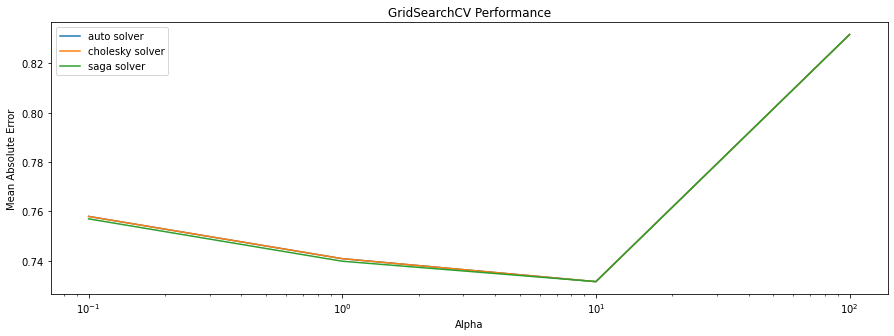

MAE on train set 0.6482120844346391
R^2 on train set 0.6320024787170404


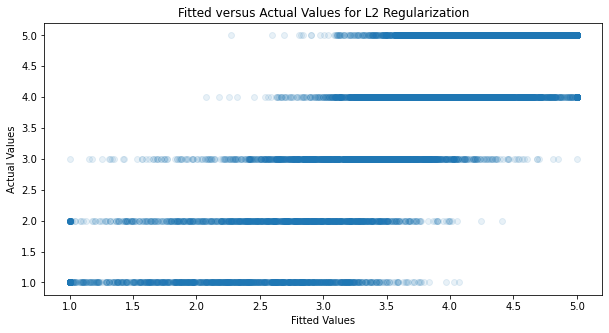

MAE on test set 0.6874885558094418
R^2 on test set 0.553706863173536


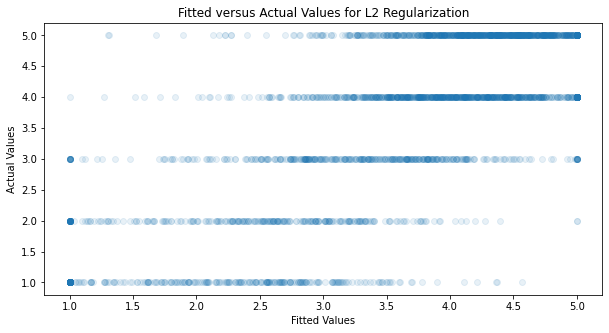

In [81]:
plot_GS_lin_reg(solver_grid, alpha_grid, grid_search)

ridge_reg.fit(X_train_scaled_1a, y_train)
fitted_values = bound_predict(ridge_reg.predict(X_train_scaled_1a))
print(f'MAE on train set {custom_mae_scorer_func(y_train, fitted_values)}')
print(f'R^2 on train set {custom_r2_scorer_func(y_train, fitted_values)}')
plot_fitted_values(fitted_values, y_train, 'L2 Regularization')

fitted_values = bound_predict(ridge_reg.predict(X_test_scaled_1a))
print(f'MAE on test set {custom_mae_scorer_func(y_test, fitted_values)}')
print(f'R^2 on test set {custom_r2_scorer_func(y_test, fitted_values)}')
plot_fitted_values(fitted_values, y_test, 'L2 Regularization')

#### Bag of Words with Lemmatization 

In [82]:
%%time

solver_grid = ['auto', 'cholesky', 'saga']
alpha_grid = [0.1, 1, 10, 100]

param_grid = [{'solver': solver_grid,
              'alpha': alpha_grid}]

grid_search = GridSearchCV(Ridge(), param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=1, n_jobs=-1)

grid_search.fit(X_train_scaled_1b, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 6.44 s, sys: 808 ms, total: 7.25 s
Wall time: 1min 58s


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid=[{'alpha': [0.1, 1, 10, 100],
                          'solver': ['auto', 'cholesky', 'saga']}],
             refit='custom_mae_scorer',
             scoring={'custom_mae_scorer': make_scorer(custom_mae_scorer_func, greater_is_better=False),
                      'custom_r2_scorer': make_scorer(custom_r2_scorer_func)},
             verbose=1)

In [83]:
grid_search.best_params_

{'alpha': 10, 'solver': 'auto'}

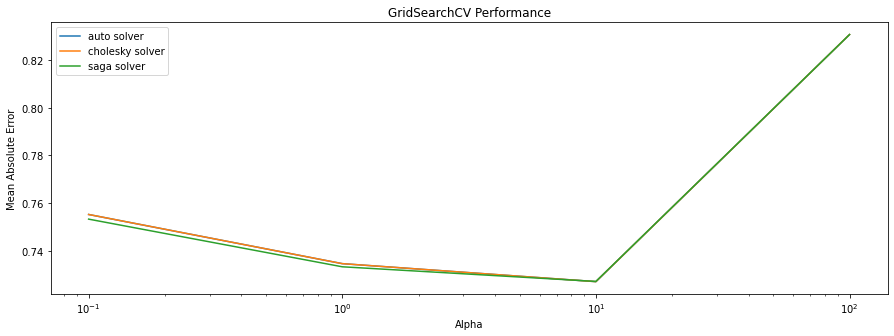

MAE on train set 0.6383254324900518
R^2 on train set 0.6417692898257787


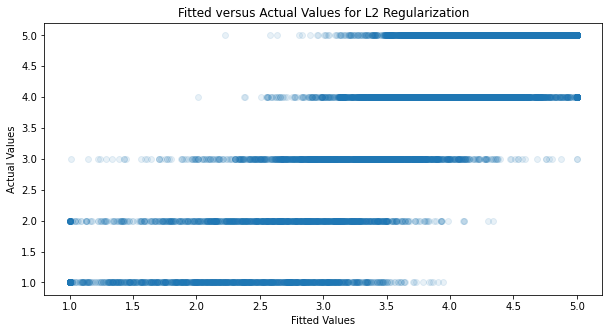

MAE on test set 0.6873190822411611
R^2 on test set 0.5549465141910224


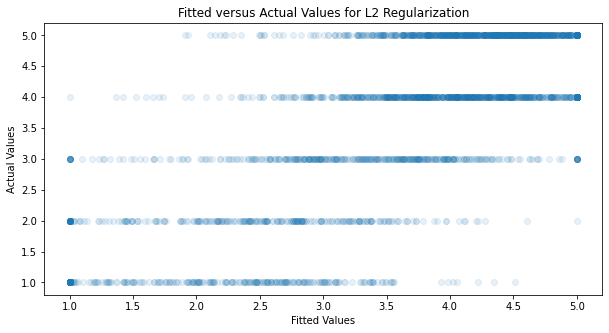

In [84]:
ridge_reg = grid_search.best_estimator_

plot_GS_lin_reg(solver_grid, alpha_grid, grid_search)

ridge_reg.fit(X_train_scaled_1b, y_train)
fitted_values = bound_predict(ridge_reg.predict(X_train_scaled_1b))
print(f'MAE on train set {custom_mae_scorer_func(y_train, fitted_values)}')
print(f'R^2 on train set {custom_r2_scorer_func(y_train, fitted_values)}')
plot_fitted_values(fitted_values, y_train, 'L2 Regularization')

fitted_values = bound_predict(ridge_reg.predict(X_test_scaled_1b))
print(f'MAE on test set {custom_mae_scorer_func(y_test, fitted_values)}')
print(f'R^2 on test set {custom_r2_scorer_func(y_test, fitted_values)}')
plot_fitted_values(fitted_values, y_test, 'L2 Regularization')

#### TF-IDF with Stemming

In [85]:
%%time

solver_grid = ['auto', 'cholesky', 'saga']
alpha_grid = [0.1, 1, 10, 100]

param_grid = [{'solver': solver_grid,
              'alpha': alpha_grid}]

grid_search = GridSearchCV(Ridge(), param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=1, n_jobs=-1)

grid_search.fit(X_train_scaled_2a, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 3.8 s, sys: 331 ms, total: 4.13 s
Wall time: 1min 50s


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid=[{'alpha': [0.1, 1, 10, 100],
                          'solver': ['auto', 'cholesky', 'saga']}],
             refit='custom_mae_scorer',
             scoring={'custom_mae_scorer': make_scorer(custom_mae_scorer_func, greater_is_better=False),
                      'custom_r2_scorer': make_scorer(custom_r2_scorer_func)},
             verbose=1)

In [86]:
grid_search.best_params_

{'alpha': 10, 'solver': 'saga'}

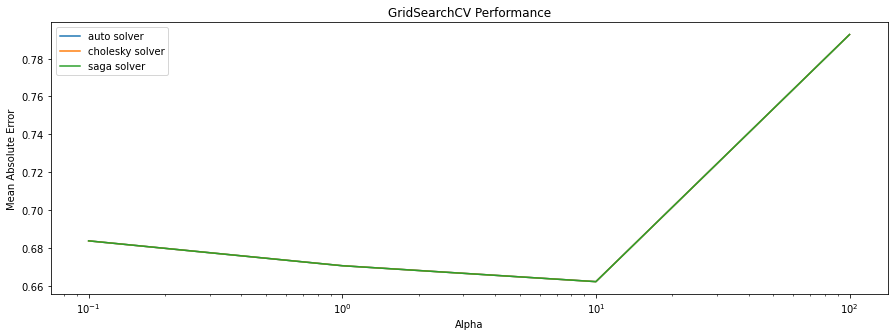

MAE on train set 0.5761753207440052
R^2 on train set 0.703565035293647


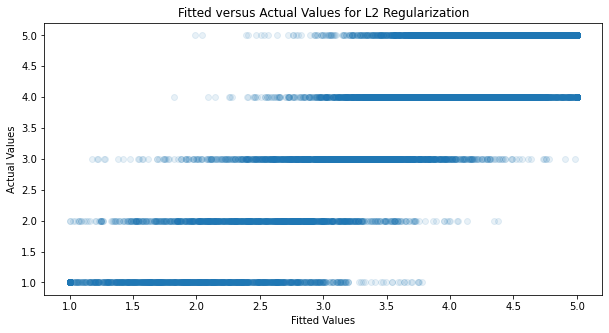

MAE on test set 0.6218783206444325
R^2 on test set 0.6245280666499526


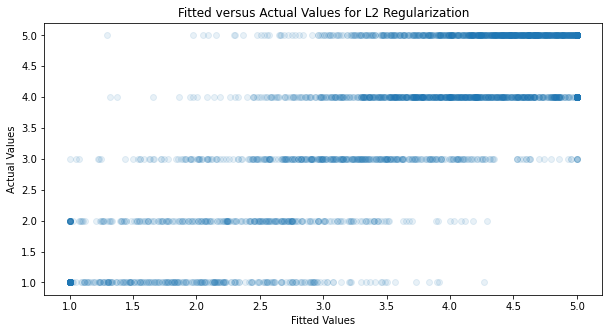

In [87]:
ridge_reg = grid_search.best_estimator_

plot_GS_lin_reg(solver_grid, alpha_grid, grid_search)

ridge_reg.fit(X_train_scaled_2a, y_train)
fitted_values = bound_predict(ridge_reg.predict(X_train_scaled_2a))
print(f'MAE on train set {custom_mae_scorer_func(y_train, fitted_values)}')
print(f'R^2 on train set {custom_r2_scorer_func(y_train, fitted_values)}')
plot_fitted_values(fitted_values, y_train, 'L2 Regularization')

fitted_values = bound_predict(ridge_reg.predict(X_test_scaled_2a))
print(f'MAE on test set {custom_mae_scorer_func(y_test, fitted_values)}')
print(f'R^2 on test set {custom_r2_scorer_func(y_test, fitted_values)}')
plot_fitted_values(fitted_values, y_test, 'L2 Regularization')

#### TF-IDF with Lemmatization

In [88]:
%%time

solver_grid = ['auto', 'cholesky', 'saga']
alpha_grid = [0.1, 1, 10, 100]

param_grid = [{'solver': solver_grid,
              'alpha': alpha_grid}]

grid_search = GridSearchCV(Ridge(), param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=1, n_jobs=-1)

grid_search.fit(X_train_scaled_2b, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 6.73 s, sys: 606 ms, total: 7.33 s
Wall time: 1min 51s


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid=[{'alpha': [0.1, 1, 10, 100],
                          'solver': ['auto', 'cholesky', 'saga']}],
             refit='custom_mae_scorer',
             scoring={'custom_mae_scorer': make_scorer(custom_mae_scorer_func, greater_is_better=False),
                      'custom_r2_scorer': make_scorer(custom_r2_scorer_func)},
             verbose=1)

In [89]:
grid_search.best_params_

{'alpha': 10, 'solver': 'auto'}

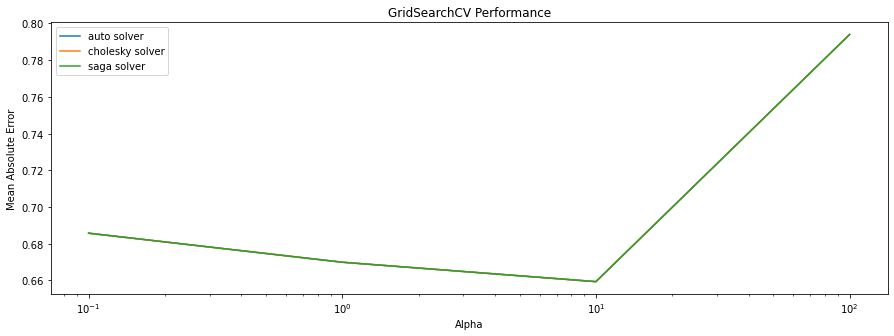

MAE on train set 0.5686426937891215
R^2 on train set 0.7106501440046284


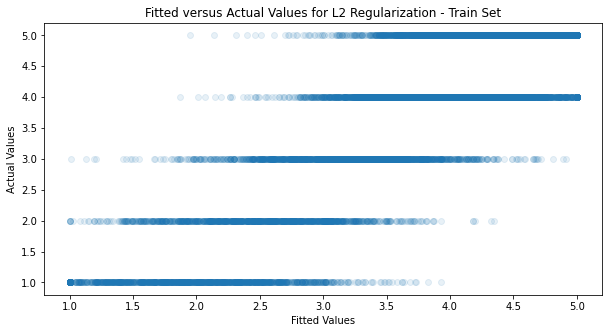

MAE on test set 0.6193262862350661
R^2 on test set 0.6298352284773497


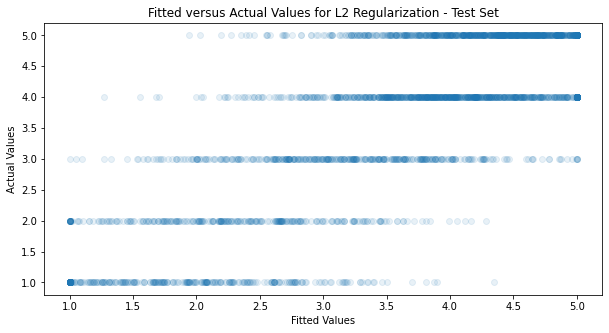

In [90]:
ridge_reg = grid_search.best_estimator_

plot_GS_lin_reg(solver_grid, alpha_grid, grid_search)

ridge_reg.fit(X_train_scaled_2b, y_train)
fitted_values = bound_predict(ridge_reg.predict(X_train_scaled_2b))
print(f'MAE on train set {custom_mae_scorer_func(y_train, fitted_values)}')
print(f'R^2 on train set {custom_r2_scorer_func(y_train, fitted_values)}')
plot_fitted_values(fitted_values, y_train, 'L2 Regularization - Train Set')

fitted_values = bound_predict(ridge_reg.predict(X_test_scaled_2b))
print(f'MAE on test set {custom_mae_scorer_func(y_test, fitted_values)}')
print(f'R^2 on test set {custom_r2_scorer_func(y_test, fitted_values)}')
plot_fitted_values(fitted_values, y_test, 'L2 Regularization - Test Set')

### Lasso Regularization

In [91]:
%%time

scores = pd.DataFrame(columns=['transformer', 'alpha', 'MAE', 'R-squared'])

for power in range(-5, 4, 1):
    alpha = 10**power
    lasso_reg = Lasso(alpha=alpha)

    
    cv_scores_1a = cross_validate(lasso_reg, X_train_scaled_1a, y_train, cv=5,
                               scoring=scorer, n_jobs=-1, verbose=1)

    scores = scores.append({'transformer': '1a',
                            'alpha': alpha,
                            'MAE': np.mean(-cv_scores_1a['test_custom_mae_scorer']),
                            'R-squared': np.mean(cv_scores_1a['test_custom_r2_scorer'])}, ignore_index=True)
    
    cv_scores_1b = cross_validate(lasso_reg, X_train_scaled_1b, y_train, cv=5,
                               scoring=scorer, n_jobs=-1, verbose=1)

    scores = scores.append({'transformer': '1b',
                            'alpha': alpha,
                            'MAE': np.mean(-cv_scores_1b['test_custom_mae_scorer']),
                            'R-squared': np.mean(cv_scores_1b['test_custom_r2_scorer'])}, ignore_index=True)
    
    cv_scores_2a = cross_validate(lasso_reg, X_train_scaled_2a, y_train, cv=5,
                               scoring=scorer, n_jobs=-1, verbose=1)

    scores = scores.append({'transformer': '2a',
                            'alpha': alpha,
                            'MAE': np.mean(-cv_scores_2a['test_custom_mae_scorer']),
                            'R-squared': np.mean(cv_scores_2a['test_custom_r2_scorer'])}, ignore_index=True)
    
    cv_scores_2b = cross_validate(lasso_reg, X_train_scaled_2b, y_train, cv=5,
                               scoring=scorer, n_jobs=-1, verbose=1)

    scores = scores.append({'transformer': '2b',
                            'alpha': alpha,
                            'MAE': np.mean(-cv_scores_2b['test_custom_mae_scorer']),
                            'R-squared': np.mean(cv_scores_2b['test_custom_r2_scorer'])}, ignore_index=True)
    
    
scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out

CPU times: user 2.32 s, sys: 2.74 s, total: 5.06 s
Wall time: 2min 29s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


,transformer,alpha,MAE,R-squared
0,1a,0.00001,0.755904,0.478206
1,1b,0.00001,0.752308,0.480209
2,2a,0.00001,0.681349,0.566944
3,2b,0.00001,0.682429,0.561795
4,1a,0.00010,0.730840,0.523088
5,1b,0.00010,0.721696,0.531245
6,2a,0.00010,0.660076,0.599302
7,2b,0.00010,0.655626,0.601394
8,1a,0.00100,0.749715,0.516497
9,1b,0.00100,0.748449,0.518084


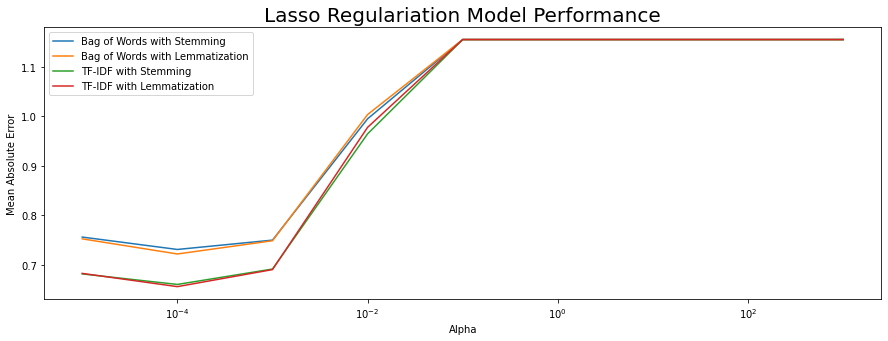

In [92]:
plt.figure(figsize=(15,5))
for transformer in scores['transformer'].unique():
    temp_df = scores[scores['transformer']==transformer]
    plt.plot(temp_df['alpha'], temp_df['MAE'], label=trans_dict[transformer])
    
plt.legend()
plt.xscale('log')
plt.title('Lasso Regulariation Model Performance', fontsize=20)
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error')

plt.show()

MAE on train set 0.5335399117734474
R^2 on train set 0.7377401446338794


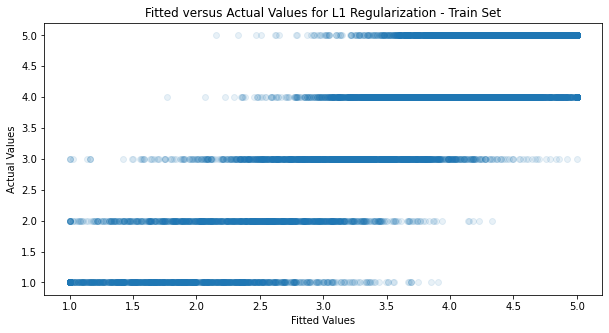

MAE on test set 0.6302551218367612
R^2 on test set 0.5983744884005526


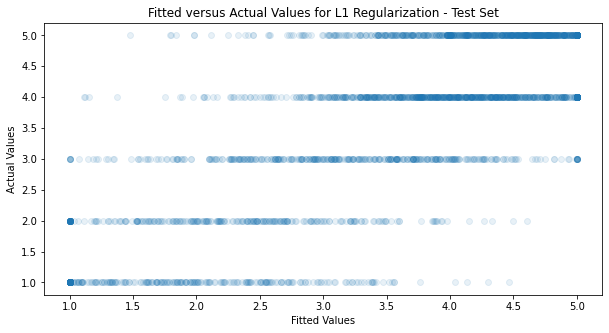

In [93]:
lasso_reg = Lasso(alpha=10**(-4))

lasso_reg.fit(X_train_scaled_2b, y_train)
fitted_values = bound_predict(lasso_reg.predict(X_train_scaled_2b))
print(f'MAE on train set {custom_mae_scorer_func(y_train, fitted_values)}')
print(f'R^2 on train set {custom_r2_scorer_func(y_train, fitted_values)}')
plot_fitted_values(fitted_values, y_train, 'L1 Regularization - Train Set')

fitted_values = bound_predict(lasso_reg.predict(X_test_scaled_2b))
print(f'MAE on test set {custom_mae_scorer_func(y_test, fitted_values)}')
print(f'R^2 on test set {custom_r2_scorer_func(y_test, fitted_values)}')
plot_fitted_values(fitted_values, y_test, 'L1 Regularization - Test Set')

### Most Predictive Words Based on Ridge Regression

In [94]:
tokens = [column for column in X_train_scaled_2b.columns if 'review__' in column]
len(tokens)

2453

In [95]:
first_token_index = X_train_scaled_2b.columns.get_loc(tokens[0])
first_token_index

52

In [96]:
token_coef_df = pd.DataFrame({'coefficient': [ridge_reg.coef_[i] for i in range(first_token_index,
                                                                                      X_train_scaled_2b.shape[1],1)],
                             'token': pd.Series(tokens).str.replace('review__', '')}).sort_values("coefficient", ascending=False)

token_coef_df.head()

,coefficient,token
270,1.442381,best
132,1.366733,amazing
1001,1.234576,great
211,1.077458,awesome
650,1.076497,delicious


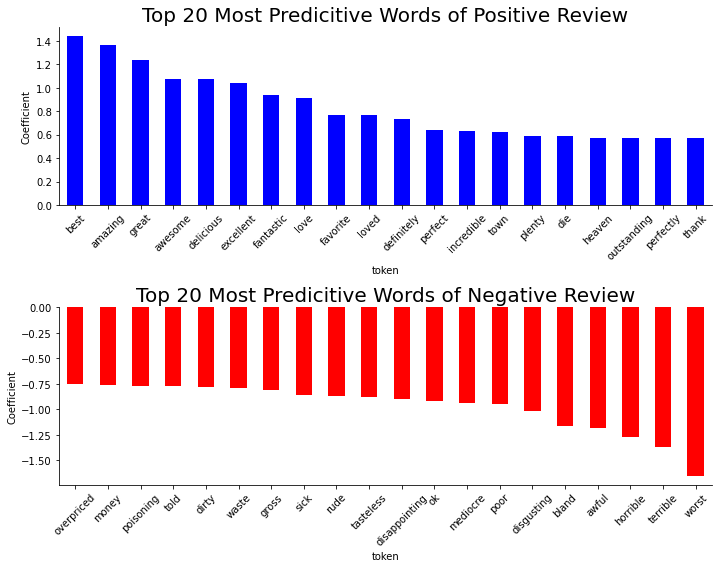

In [97]:
# Plot the top 20 most predictive words
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Most predictive words of a positive review
token_coef_df.head(20).set_index("token").plot(kind="bar", rot=45, ax=ax[0], color="blue", legend=False)
ax[0].set_title("Top 20 Most Predicitive Words of Positive Review", fontsize=20)
ax[0].set_ylabel('Coefficient')

# Most predictive words of a negative review
token_coef_df.tail(20).set_index("token").plot(kind="bar", rot=45, ax=ax[1], color="red", legend=False)
ax[1].set_title("Top 20 Most Predicitive Words of Negative Review", fontsize=20)
ax[1].set_ylabel('Coefficient')

sns.despine()
plt.tight_layout()
plt.show()

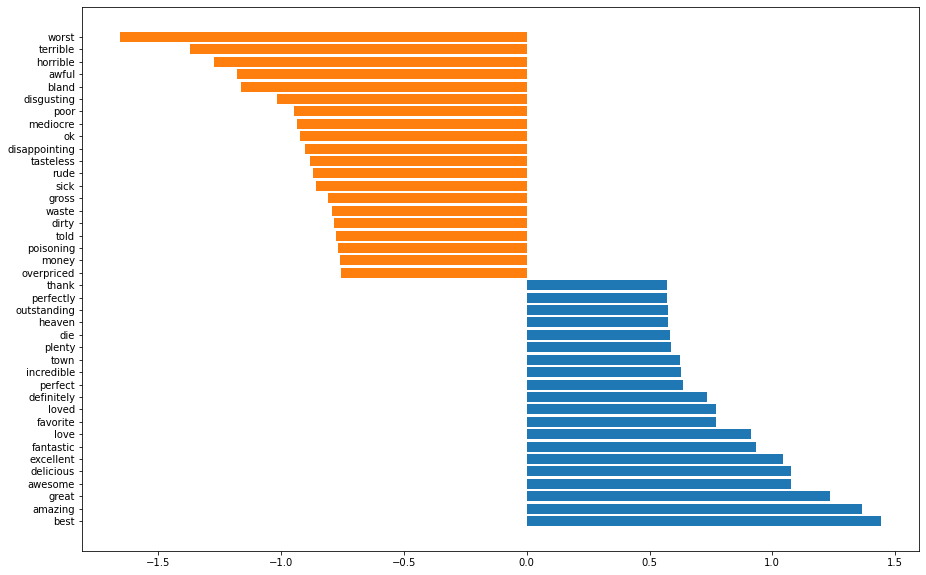

In [98]:
plt.figure(figsize=(15,10))
plt.barh(token_coef_df['token'].head(20),token_coef_df.head(20)["coefficient"])
plt.barh(token_coef_df['token'].tail(20),token_coef_df.tail(20)["coefficient"])

plt.show()

### XGBoost

In [107]:
%%time

xgboost_reg = XGBRegressor(n_estimators=1000, learning_rate=0.1)

    
cv_scores = cross_validate(xgboost_reg, X_train_unscaled_2b, y_train, cv=5,
                           scoring=scorer, verbose=4, n_jobs=-1)



print(f"MAE: {np.mean(-cv_scores['test_custom_mae_scorer'])}")
print(f"R^2: {np.mean(cv_scores['test_custom_r2_scorer'])}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 18.2min remaining: 27.3min


MAE: 0.6734806499268396
R^2: 0.588764748619519
CPU times: user 173 ms, sys: 323 ms, total: 496 ms
Wall time: 18min 14s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 18.2min finished


[CV] END  custom_mae_scorer: (test=-0.674) custom_r2_scorer: (test=0.603) total time=18.2min
[CV] END  custom_mae_scorer: (test=-0.689) custom_r2_scorer: (test=0.573) total time=18.2min
[CV] END  custom_mae_scorer: (test=-0.664) custom_r2_scorer: (test=0.592) total time=18.2min
[CV] END  custom_mae_scorer: (test=-0.673) custom_r2_scorer: (test=0.586) total time=18.2min
[CV] END  custom_mae_scorer: (test=-0.668) custom_r2_scorer: (test=0.590) total time=18.2min


In [108]:
%%time

xgboost_reg = XGBRegressor(n_estimators=1000, learning_rate=0.1, alpha=0.01)

    
cv_scores = cross_validate(xgboost_reg, X_train_unscaled_2b, y_train, cv=5,
                           scoring=scorer, verbose=4, n_jobs=-2)



print(f"MAE: {np.mean(-cv_scores['test_custom_mae_scorer'])}")
print(f"R^2: {np.mean(cv_scores['test_custom_r2_scorer'])}")

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed: 17.7min remaining: 26.6min


MAE: 0.6700127242230257
R^2: 0.5924365784595343
CPU times: user 136 ms, sys: 237 ms, total: 373 ms
Wall time: 17min 44s


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed: 17.7min finished


In [110]:
%%time

xgboost_reg = XGBRegressor(n_estimators=1000, learning_rate=0.1, alpha=10)

    
cv_scores = cross_validate(xgboost_reg, X_train_unscaled_2b, y_train, cv=5,
                           scoring=scorer, verbose=4, n_jobs=-2)



print(f"MAE: {np.mean(-cv_scores['test_custom_mae_scorer'])}")
print(f"R^2: {np.mean(cv_scores['test_custom_r2_scorer'])}")

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed: 12.6min remaining: 18.9min


MAE: 0.6671315800733806
R^2: 0.5962207149722933
CPU times: user 118 ms, sys: 186 ms, total: 304 ms
Wall time: 12min 50s


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed: 12.8min finished


[CV] END  custom_mae_scorer: (test=-0.664) custom_r2_scorer: (test=0.594) total time=17.7min
[CV] END  custom_mae_scorer: (test=-0.665) custom_r2_scorer: (test=0.594) total time=17.3min
[CV] END  custom_mae_scorer: (test=-0.655) custom_r2_scorer: (test=0.602) total time=12.2min
[CV] END  custom_mae_scorer: (test=-0.666) custom_r2_scorer: (test=0.594) total time=17.7min
[CV] END  custom_mae_scorer: (test=-0.670) custom_r2_scorer: (test=0.588) total time=17.3min
[CV] END  custom_mae_scorer: (test=-0.683) custom_r2_scorer: (test=0.585) total time=12.6min
[CV] END  custom_mae_scorer: (test=-0.660) custom_r2_scorer: (test=0.598) total time=17.7min
[CV] END  custom_mae_scorer: (test=-0.688) custom_r2_scorer: (test=0.574) total time=17.3min
[CV] END  custom_mae_scorer: (test=-0.661) custom_r2_scorer: (test=0.592) total time=12.7min
[CV] END  custom_mae_scorer: (test=-0.671) custom_r2_scorer: (test=0.605) total time=17.7min
[CV] END  custom_mae_scorer: (test=-0.672) custom_r2_scorer: (test=0.5

In [111]:
%%time

xgboost_reg = XGBRegressor(n_estimators=2000, learning_rate=0.05, alpha=10)

    
cv_scores = cross_validate(xgboost_reg, X_train_unscaled_2b, y_train, cv=5,
                           scoring=scorer, verbose=4, n_jobs=-2)



print(f"MAE: {np.mean(-cv_scores['test_custom_mae_scorer'])}")
print(f"R^2: {np.mean(cv_scores['test_custom_r2_scorer'])}")

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed: 25.8min remaining: 38.8min


MAE: 0.665068735442276
R^2: 0.598093124199513
CPU times: user 164 ms, sys: 271 ms, total: 435 ms
Wall time: 26min 12s


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed: 26.2min finished


In [112]:
%%time

xgboost_reg = XGBRegressor(n_estimators=1000, learning_rate=0.01, alpha=100)

    
cv_scores = cross_validate(xgboost_reg, X_train_unscaled_2b, y_train, cv=5,
                           scoring=scorer, verbose=4, n_jobs=-2)



print(f"MAE: {np.mean(-cv_scores['test_custom_mae_scorer'])}")
print(f"R^2: {np.mean(cv_scores['test_custom_r2_scorer'])}")

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed: 18.6min remaining: 27.9min


MAE: 0.7503572605361148
R^2: 0.5236729231755168
CPU times: user 129 ms, sys: 194 ms, total: 323 ms
Wall time: 18min 37s


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed: 18.6min finished


[CV] END  custom_mae_scorer: (test=-0.658) custom_r2_scorer: (test=0.595) total time=26.2min
[CV] END  custom_mae_scorer: (test=-0.741) custom_r2_scorer: (test=0.528) total time=18.6min
[CV] END  custom_mae_scorer: (test=-0.679) custom_r2_scorer: (test=0.597) total time=26.2min
[CV] END  custom_mae_scorer: (test=-0.764) custom_r2_scorer: (test=0.510) total time=18.6min
[CV] END  custom_mae_scorer: (test=-0.675) custom_r2_scorer: (test=0.591) total time=25.8min
[CV] END  custom_mae_scorer: (test=-0.744) custom_r2_scorer: (test=0.529) total time=18.6min
[CV] END  custom_mae_scorer: (test=-0.661) custom_r2_scorer: (test=0.599) total time=25.8min
[CV] END  custom_mae_scorer: (test=-0.748) custom_r2_scorer: (test=0.519) total time=18.6min
[CV] END  custom_mae_scorer: (test=-0.653) custom_r2_scorer: (test=0.609) total time=26.1min
[CV] END  custom_mae_scorer: (test=-0.756) custom_r2_scorer: (test=0.532) total time=18.6min


In [190]:
%%time

param_grid = [{'max_depth': [6, 10], 'alpha': [0.1, 1, 10], 'n_estimators': [1000], 'learning_rate': [0.1]},
             {'max_depth': [6, 10], 'alpha': [0.1, 1, 10], 'n_estimators': [2000], 'learning_rate': [0.01]}]

grid_search = GridSearchCV(XGBRegressor(random_state=0, verbosity=1), param_grid, cv=5,
                           scoring=scorer, refit='custom_mae_scorer',
                           verbose=3, n_jobs=-2)

grid_search.fit(X_train_unscaled_2b, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END alpha=0.1, learning_rate=0.1, max_depth=6, n_estimators=1000; custom_mae_scorer: (test=-0.664) custom_r2_scorer: (test=0.595) total time=40.2min
[CV 1/5] END alpha=1, learning_rate=0.1, max_depth=10, n_estimators=1000; custom_mae_scorer: (test=-0.660) custom_r2_scorer: (test=0.592) total time=67.6min
[CV 4/5] END alpha=0.1, learning_rate=0.01, max_depth=6, n_estimators=2000; custom_mae_scorer: (test=-0.690) custom_r2_scorer: (test=0.587) total time=70.7min
[CV 5/5] END alpha=1, learning_rate=0.01, max_depth=6, n_estimators=2000; custom_mae_scorer: (test=-0.679) custom_r2_scorer: (test=0.592) total time=74.8min
[CV 3/5] END alpha=10, learning_rate=0.01, max_depth=6, n_estimators=2000; custom_mae_scorer: (test=-0.696) custom_r2_scorer: (test=0.586) total time=72.5min
[CV 4/5] END alpha=0.1, learning_rate=0.1, max_depth=10, n_estimators=1000; custom_mae_scorer: (test=-0.674) custom_r2_scorer: (test=0.584) total time

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
             param_grid=[{'alpha': [0.1, 1, 10], 'learning_rate': [0.1],
                          'max_depth': [6, 10], 'n_estimators': [1000]},
                         {'alpha': [0.1, 1, 10], 'learning_rate': [0.01],
                          'max_depth

In [228]:
grid_search.best_params_

{'alpha': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}

In [229]:
grid_search.best_score_

-0.6615616113689923

In [230]:
xgb_reg = grid_search.best_estimator_
xgb_reg

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

MAE on train set 0.23486744478566018
R^2 on train set 0.9419761249723709


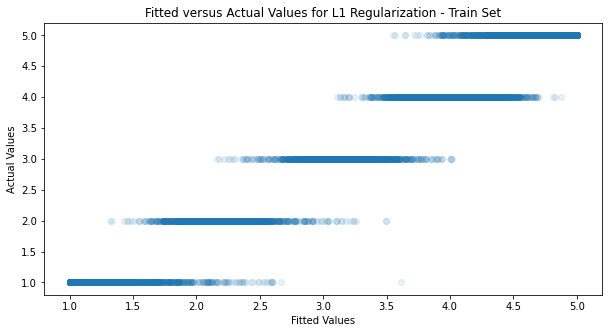

MAE on test set 0.6527038334053514
R^2 on test set 0.6148820701857625


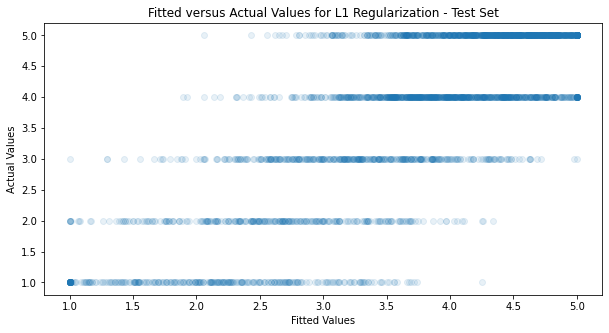

CPU times: user 50min 20s, sys: 9.42 s, total: 50min 29s
Wall time: 4min 26s


In [232]:
%%time

xgb_reg.fit(X_train_unscaled_2b, y_train)
fitted_values = bound_predict(xgb_reg.predict(X_train_unscaled_2b))
print(f'MAE on train set {custom_mae_scorer_func(y_train, fitted_values)}')
print(f'R^2 on train set {custom_r2_scorer_func(y_train, fitted_values)}')
plot_fitted_values(fitted_values, y_train, 'L1 Regularization - Train Set')

fitted_values = bound_predict(xgb_reg.predict(X_test_unscaled_2b))
print(f'MAE on test set {custom_mae_scorer_func(y_test, fitted_values)}')
print(f'R^2 on test set {custom_r2_scorer_func(y_test, fitted_values)}')
plot_fitted_values(fitted_values, y_test, 'L1 Regularization - Test Set')

### Decision Tree

In [191]:
# DT_model = DecisionTreeRegressor(max_depth=25, min_samples_leaf=10, random_state=0)
# DT_model.fit(X_train_scaled, y_train)

# print(mean_absolute_error(y_train, DT_model.predict(X_train_scaled)))
# print(r2_score(y_train, DT_model.predict(X_train_scaled)))

In [192]:
# fitted_values = DT_model.predict(X_test_scaled)
# print(mean_absolute_error(y_test, fitted_values))
# print(r2_score(y_test, fitted_values))
# plot_fitted_values(fitted_values, y_test, 'L1 Regularization')

In [193]:
# DT_model.get_depth()

In [194]:
# residuals = DT_model.predict(X_train) - y_train

# plot_residuals(X_train, residuals)

In [195]:
# %%time

# DT_model = DecisionTreeRegressor(min_samples_leaf=2, random_state=0)

# # Cross validation score
# scores = cross_validate(DT_model, X_train_scaled, y_train, cv=5,
#                                scoring=scorer)

# print('MAE Score:')
# print(-scores['test_custom_mae_scorer'])
# print(np.mean(-scores['test_custom_mae_scorer']))
# print('\n')


# print('R^2 Score:')
# print(scores['test_custom_r2_scorer'])
# print(np.mean(scores['test_custom_r2_scorer']))


In [196]:
# %%time

# DT_reg = DecisionTreeRegressor()

# param_grid = [{'max_depth': [25, 50, 70], 'min_samples_leaf': [2, 4, 6]}]

# grid_search = GridSearchCV(DT_reg, param_grid, cv=5, scoring=scorer, refit='custom_mae_scorer')

# grid_search.fit(X_train_scaled, y_train)

In [197]:
# grid_search.best_params_

In [198]:
# best_DT_reg = grid_search.best_estimator_
# best_DT_reg

In [199]:
# best_DT_reg.fit(X_train_scaled, y_train)
# fitted_values = bound_predict(best_DT_reg.predict(X_train_scaled))
# print(mean_absolute_error(y_train, fitted_values))
# print(r2_score(y_train, fitted_values))
# plot_fitted_values(fitted_values, y_train, 'Optimized Decision Tree')

In [200]:
# fitted_values = bound_predict(best_DT_reg.predict(X_test_scaled))
# print(mean_absolute_error(y_test, fitted_values))
# print(r2_score(y_test, fitted_values))
# plot_fitted_values(fitted_values, y_test, 'Optimized Decision Tree')

### Random Forest

In [201]:
# %%time

# forest_reg = RandomForestRegressor(n_estimators=500, max_depth = 25, min_samples_leaf = 6)

    
# cv_scores = cross_validate(forest_reg, X_train_unscaled, y_train, cv=5,
#                            scoring=scorer, verbose=4, n_jobs=-1)



# print(f"MAE: {np.mean(-cv_scores['test_custom_mae_scorer'])}")
# print(f"R^2: {np.mean(cv_scores['test_custom_r2_scorer'])}")

In [202]:
# %%time

# forest_reg = RandomForestRegressor(n_estimators=500, min_samples_leaf = 2, n_jobs=-1)

    
# cv_scores = cross_validate(forest_reg, X_train_unscaled, y_train, cv=5,
#                            scoring=scorer, verbose=4, n_jobs=-1)



# print(f"MAE: {np.mean(-cv_scores['test_custom_mae_scorer'])}")
# print(f"R^2: {np.mean(cv_scores['test_custom_r2_scorer'])}")

In [203]:
# %%time

# scores = pd.DataFrame(columns=['n_estimators', 'MAE', 'R-squared'])

# for n in range(100, 102, 25):
#     forest_reg = RandomForestRegressor(n_estimators=n, max_depth = 25, min_samples_leaf = 6)

    
#     cv_scores = cross_validate(forest_reg, X_train_unscaled, y_train, cv=5,
#                                scoring=scorer)

#     scores = scores.append({'n_estimators': n,
#                                     'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
#                                     'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])}, ignore_index=True)
    
    
# scores



### TF-IDF Vectorizer

In [204]:
# col_trans_2 = ColumnTransformer([
#     ('cat', OneHotEncoder(drop='first'), categorical_columns),
#     ('review', TfidfVectorizer(min_df=25, tokenizer=my_tokenizer), 'text')
# ])

In [205]:
# col_trans_2.fit(X_train)
# temp_df = col_trans_2.transform(X_train).todense()
# temp_df = pd.DataFrame(columns=col_trans_2.get_feature_names_out(), data=temp_df, index=X_train.index)
# X_train_unscaled = pd.concat([X_train.drop(categorical_columns+['text'], axis=1), temp_df], axis=1)

# temp_df = col_trans_2.transform(X_test).todense()
# temp_df = pd.DataFrame(columns=col_trans_2.get_feature_names_out(), data=temp_df, index=X_test.index)
# X_test_unscaled = pd.concat([X_test.drop(categorical_columns+['text'], axis=1), temp_df], axis=1)

In [206]:
# X_train_unscaled.head()

In [207]:
# X_train_unscaled.head()

In [208]:
# X_test_unscaled.head()

In [209]:
# # Fit the scaler to X_rem and transform X_rem
# X_train_scaled = scaler.fit_transform(X_train_unscaled)

# # Transform X_test using the fitted scaler
# X_test_scaled= scaler.transform(X_test_unscaled)

# # Redefine numpy arrays as dataframes
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_unscaled.columns)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_unscaled.columns)

# # Print shapes
# print(f'Shape of scaled remainder set: {X_train_scaled.shape}')
# print(f'Shape of scaled test set: {X_test_scaled.shape}')

In [210]:
# %%time

# scores = pd.DataFrame(columns=['alpha', 'MAE', 'R-squared'])

# for power in range(-4, 4, 1):
#     alpha = 10**power
#     ridge_reg = Ridge(alpha=alpha)

    
#     cv_scores = cross_validate(ridge_reg, X_train_scaled, y_train, cv=5,
#                                scoring=scorer)

#     scores = scores.append({'alpha': alpha,
#                                     'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
#                                     'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])}, ignore_index=True)
    
    
# scores
    

In [211]:
# regression_plots(scores, 'L2 Regularization with TF-IDF')

In [212]:
# ridge_reg = Ridge(alpha=10)
# ridge_reg.fit(X_train_scaled, y_train)
# fitted_values = bound_predict(ridge_reg.predict(X_train_scaled))
# print(custom_mae_scorer_func(y_train, fitted_values))
# print(custom_r2_scorer_func(y_train, fitted_values))

In [213]:
# ridge_reg = Ridge(alpha=10)
# ridge_reg.fit(X_test_scaled, y_test)
# fitted_values = bound_predict(ridge_reg.predict(X_test_scaled))
# print(custom_mae_scorer_func(y_test, fitted_values))
# print(custom_r2_scorer_func(y_test, fitted_values))

In [214]:
# tokens = [column for column in X_train_scaled.columns if 'review__' in column]
# len(tokens)

In [215]:
# first_token_index = X_train_scaled.columns.get_loc(tokens[0])
# first_token_index

In [216]:
# token_coef_df = pd.DataFrame({'coefficient': [ridge_reg.coef_[i] for i in range(first_token_index,
#                                                                                       X_train_scaled.shape[1],1)],
#                              'token': pd.Series(tokens).str.replace('review__', '')}).sort_values("coefficient", ascending=False)

# token_coef_df.head()

In [217]:
# plt.figure(figsize=(15,10))
# plt.barh(token_coef_df['token'].head(20),token_coef_df.head(20)["coefficient"])
# plt.barh(token_coef_df['token'].tail(20),token_coef_df.tail(20)["coefficient"])

# plt.show()

In [218]:
# %%time

# forest_reg = RandomForestRegressor(n_estimators=500, min_samples_leaf = 2, n_jobs=-1)

    
# cv_scores = cross_validate(forest_reg, X_train_unscaled, y_train, cv=5,
#                            scoring=scorer, verbose=4, n_jobs=-1)



# print(f"MAE: {np.mean(-cv_scores['test_custom_mae_scorer'])}")
# print(f"R^2: {np.mean(cv_scores['test_custom_r2_scorer'])}")

In [219]:
# %%time

# scores = pd.DataFrame(columns=['n_estimators', 'MAE', 'R-squared'])

# for n in range(100, 102, 25):
#     forest_reg = RandomForestRegressor(n_estimators=n, max_depth = 25, min_samples_leaf = 6)

    
#     cv_scores = cross_validate(forest_reg, X_train_unscaled, y_train, cv=5,
#                                scoring=scorer)

#     scores = scores.append({'n_estimators': n,
#                                     'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
#                                     'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])}, ignore_index=True)
    
    
# scores

In [220]:
# %%time

# forest_reg = RandomForestRegressor()

# param_grid = [{'max_depth': [20, 25, 30], 'min_samples_leaf': [2, 4], 'n_estimators': [75, 100, 125]}]

# grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring=scorer, refit='custom_mae_scorer', verbose=4)

# grid_search.fit(X_train_unscaled, y_train)

In [221]:
# grid_search.best_params_

In [222]:
# best_forest_reg = grid_search.best_estimator_
# best_forest_reg

In [223]:
# %%time

# best_forest_reg.fit(X_train_unscaled, y_train)
# fitted_values = bound_predict(best_forest_reg.predict(X_train_unscaled))
# print(mean_absolute_error(y_train, fitted_values))
# print(r2_score(y_train, fitted_values))
# plot_fitted_values(fitted_values, y_train, 'Optimized Random Forest')

In [224]:
# fitted_values = bound_predict(best_forest_reg.predict(X_test_unscaled))
# print(mean_absolute_error(y_test, fitted_values))
# print(r2_score(y_test, fitted_values))
# plot_fitted_values(fitted_values, y_test, 'Optimized Decision Tree')

#### Gradient Boosting

In [225]:
# %%time

# grad_boost_reg = GradientBoostingRegressor(n_estimators=500, random_state=0, min_samples_leaf=6)

# param_grid = [{'max_depth': [25, 35],
#                'min_samples_leaf': [4, 6],
#                'learning_rate': [0.1, 1],
#                'max_features': [0.33, 0.66, 1.0]}]

# grid_search = GridSearchCV(grad_boost_reg, param_grid, cv=5,
#                            scoring=scorer, refit='custom_mae_scorer',
#                            verbose=4, n_jobs=-1)

# grid_search.fit(X_train_unscaled, y_train)

In [226]:
%%time

grad_boost_reg = GradientBoostingRegressor(n_estimators=1000, random_state=0,
                                           learning_rate=0.1,
                                           max_features=1.0,
                                           min_samples_leaf = 4)

    
cv_scores = cross_validate(grad_boost_reg, X_train_unscaled, y_train, cv=5,
                           scoring=scorer, verbose=4, n_jobs=-1)



print(f"MAE: {np.mean(-cv_scores['test_custom_mae_scorer'])}")
print(f"R^2: {np.mean(cv_scores['test_custom_r2_scorer'])}")

NameError: name 'X_train_unscaled' is not defined

In [227]:
# %%time

# xgboost_reg = XGBRegressor(n_estimators=1000, eta=0.1)

    
# cv_scores = cross_validate(xgboost_reg, X_train_unscaled, y_train, cv=5,
#                            scoring=scorer, verbose=4, n_jobs=-1)



# print(f"MAE: {np.mean(-cv_scores['test_custom_mae_scorer'])}")
# print(f"R^2: {np.mean(cv_scores['test_custom_r2_scorer'])}")

[CV 5/5] END alpha=0.1, learning_rate=0.1, max_depth=6, n_estimators=1000; custom_mae_scorer: (test=-0.661) custom_r2_scorer: (test=0.594) total time=40.1min
[CV 5/5] END alpha=1, learning_rate=0.1, max_depth=6, n_estimators=1000; custom_mae_scorer: (test=-0.650) custom_r2_scorer: (test=0.604) total time=37.6min
[CV 5/5] END alpha=10, learning_rate=0.1, max_depth=6, n_estimators=1000; custom_mae_scorer: (test=-0.655) custom_r2_scorer: (test=0.602) total time=24.9min
[CV 5/5] END alpha=10, learning_rate=0.1, max_depth=10, n_estimators=1000; custom_mae_scorer: (test=-0.667) custom_r2_scorer: (test=0.589) total time=22.1min
[CV 3/5] END alpha=0.1, learning_rate=0.01, max_depth=10, n_estimators=2000; custom_mae_scorer: (test=-0.702) custom_r2_scorer: (test=0.580) total time=128.6min
[CV 4/5] END alpha=10, learning_rate=0.01, max_depth=6, n_estimators=2000; custom_mae_scorer: (test=-0.677) custom_r2_scorer: (test=0.593) total time=72.3min
[CV 5/5] END alpha=10, learning_rate=0.01, max_depth